# DS4A / COLOMBIA 4.0 

# Topic: Consumer behavior on e-Commerce

Data science for the digital future

- Ximena Rios Cotazo

- Ramon Manuel Sandoval 

- Luisa Maria Carabali

- Alejandro Camargo Garcia

- Cristian Sarmiento

- Hector Melo


## E-Commerce 

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.


## Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Taken from:[Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv )

## Topic: Consumer behavior on E-Commerce

## Research question

What aspects of consumers’ online behavior is useful for businesses to better understand their customers and predict consumer trends, spending habits, variables related to the shopping? 

## Objectives: 

-	Data understanding and cleaning
-	Analysis and modeling 
-	Build prediction models 
-	Build dashboards to visualize the insight

## Description of the relationship between datasets:

<img src="VisualData.png">





## Requirements

In [4]:
import os
from scipy import stats
import statsmodels.formula.api as sfm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import sklearn.metrics       as Metrics

In [5]:
# Ignore user warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

# Load relevant packages
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

%matplotlib inline
plt.style.use('ggplot')

In [6]:
ruta=os.getcwd()+'/data/'

In [7]:
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
order_reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',') 


# INICIO XIMENA

In this part we try to analyze which is the trend of online shopping by city.

For this analysis we generate a dataset called ```df```, which is obtained by crossing the fields: ```order_id,customer_id```, ```customer_unique_id```, ```ustomer_city,customer_state```, ```order_item_id```,  ```product_id```, ```product_category_name```   of the dataframes: ```olist_customers_dataset```, ```olist_order_items_dataset```, ```olist_orders_dataset```, ```olist_products_dataset```. For this we use pyhton's ```merge``` function:

In [32]:
# order_id:Identificador único del pedido. customer_id: Id del cliente.customer_unique_id: Identificador único de un cliente.
df1=orders[['order_id','customer_id','order_purchase_timestamp','order_status']] 
df2=customer[['customer_id','customer_city','customer_state']] 
df=pd.merge(df1, df2, how="left", left_on="customer_id", right_on="customer_id")

In [33]:
#product_id: Identificador único del producto.order_item_id: identifica el número de artículosincluido en el mismo pedido.
df3=order_items[['order_id','order_item_id','product_id','price','freight_value']] 
df3['total_price']=df3['price'] + df3['freight_value']
df=pd.merge(df, df3, how="left", left_on="order_id", right_on="order_id")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
#product_category_name:Categoría raíz del producto, en portugués
df4=products[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']] 
df4['product_vol']=df4['product_length_cm'] * df4['product_height_cm'] * df4['product_width_cm']
df=pd.merge(df, df4, how="left", left_on="product_id", right_on="product_id")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
#review_score:puntuacion entre 1 y 5
df5=order_reviews[['order_id','review_score']] 
df=pd.merge(df, df5, how="left", left_on="order_id", right_on="order_id")

Como estamos interesados en las ventas por producto, creamos una nueva columna llamada ```total_sales```:

Incluimos la informacion del tiempo

In [67]:
df['ano_mes']=df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+df['order_purchase_timestamp'].str.split('-', expand=True)[1]
df['ano_mes_dt'] = pd.to_datetime(df['ano_mes'])
df['fecha'] = pd.to_datetime(df['order_purchase_timestamp'])
df['mes']= df['fecha'].dt.month
df['year']=df['fecha'].dt.year
df.ano_mes = df.ano_mes.astype('category')
df['month_codes']= df.ano_mes.cat.codes
df.month_codes = df.month_codes.astype('category')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112777 entries, 0 to 114099
Data columns (total 27 columns):
order_id                    112777 non-null object
customer_id                 112777 non-null object
order_purchase_timestamp    112777 non-null object
order_status                112777 non-null object
customer_city               112777 non-null object
customer_state              112777 non-null object
order_item_id               112769 non-null float64
product_id                  112769 non-null object
price                       112769 non-null float64
freight_value               112769 non-null float64
total_price                 112769 non-null float64
product_category_name       111171 non-null object
product_photos_qty          111171 non-null float64
product_weight_g            112751 non-null float64
product_length_cm           112751 non-null float64
product_height_cm           112751 non-null float64
product_width_cm            112751 non-null float64
product_vol  

The states are by [ISO code](https://es.wikipedia.org/wiki/Anexo:Estados_de_Brasil), we create an dictionary (```estados```) with these codes and the corresponding name, and another dictionary (```regiones```) with the regions for each state, then we add two columns to the dataframe, one with the name of the state and the other with the region, we do this for a more comfortable viewing.

In [38]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
df['name_state']=df['customer_state']
for i in range(len(estados)):
    df["name_state"]=df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])

In [39]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
df['regions']=df['customer_state']
for i in range(len(estados)):
    df["regions"]=df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

In [40]:
df.regions  = df.regions .astype(pd.api.types.CategoricalDtype(categories=["Norte","Sur","Sudeste","Nordeste","CentroOeste"]))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114100 entries, 0 to 114099
Data columns (total 27 columns):
order_id                    114100 non-null object
customer_id                 114100 non-null object
order_purchase_timestamp    114100 non-null object
order_status                114100 non-null object
customer_city               114100 non-null object
customer_state              114100 non-null object
order_item_id               113322 non-null float64
product_id                  113322 non-null object
price                       113322 non-null float64
freight_value               113322 non-null float64
total_price                 113322 non-null float64
product_category_name       111710 non-null object
product_photos_qty          111710 non-null float64
product_weight_g            113304 non-null float64
product_length_cm           113304 non-null float64
product_height_cm           113304 non-null float64
product_width_cm            113304 non-null float64
product_vol  

In [41]:
df=df[(df.order_status!= 'canceled') & (df.order_status!= 'unavailable')]

# Total average price vs timeline 

### Data Exploration
Generamos una grafica de las ventas totales por mes

In [57]:
aux=df[["fecha","month_codes" ,"total_price"]]
aux=aux.groupby(["month_codes"]).sum()
aux


,total_price
month_codes,
0,279.69
1,51955.42
2,19.62
3,137915.19
4,284979.63
5,427614.31
6,406813.64
7,586697.33
8,503812.45


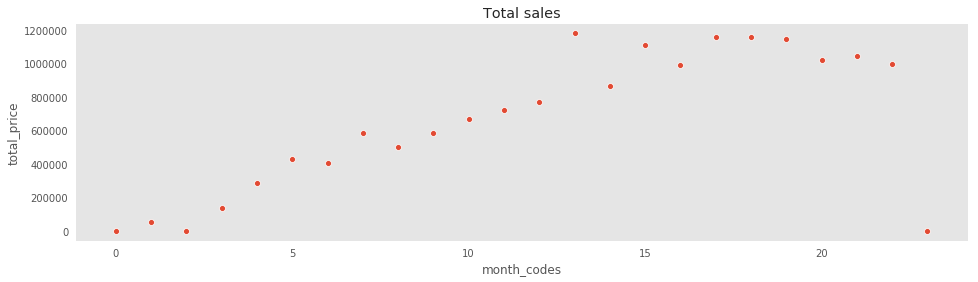

In [59]:
plt.figure(figsize=(16, 4))
aux=df[["fecha","month_codes" ,"total_price"]]
aux=aux.groupby(["month_codes"]).sum().sort_values('total_price', ascending=False).reset_index()
ax=sns.scatterplot(x='month_codes', y='total_price', data=aux)
#plt.xticks(rotation=90)
ax.set_title('Total sales')
ax.grid()

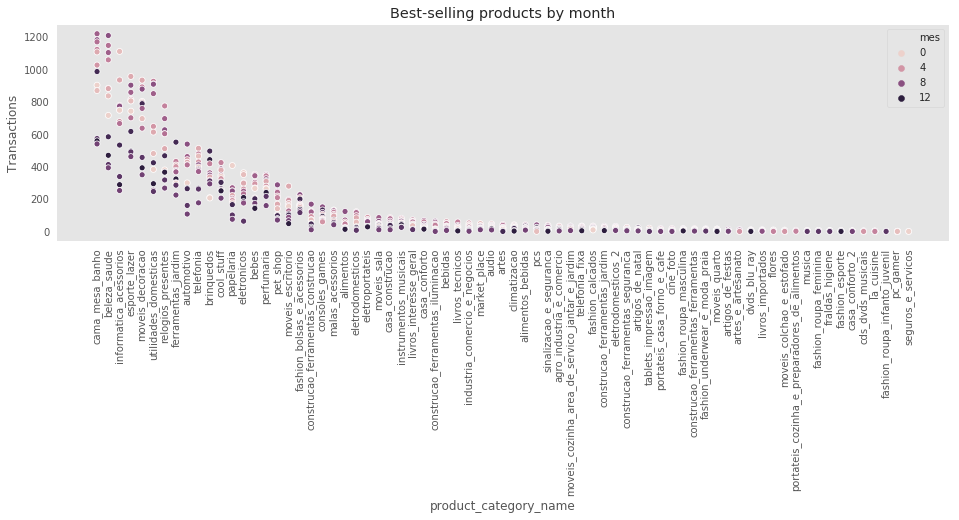

In [62]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","mes"]]
aux2=aux[(aux["mes"]>0)]
aux2=aux2.groupby(["product_category_name","mes"]).size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).reset_index()
#aux2=aux2[(aux2["Transactions"]>10)]
ax=sns.scatterplot(x='product_category_name', y='Transactions',hue="mes", data=aux2)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by month')
ax.grid()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112777 entries, 0 to 114099
Data columns (total 27 columns):
order_id                    112777 non-null object
customer_id                 112777 non-null object
order_purchase_timestamp    112777 non-null object
order_status                112777 non-null object
customer_city               112777 non-null object
customer_state              112777 non-null object
order_item_id               112769 non-null float64
product_id                  112769 non-null object
price                       112769 non-null float64
freight_value               112769 non-null float64
total_price                 112769 non-null float64
product_category_name       111171 non-null object
product_photos_qty          111171 non-null float64
product_weight_g            112751 non-null float64
product_length_cm           112751 non-null float64
product_height_cm           112751 non-null float64
product_width_cm            112751 non-null float64
product_vol  

In [103]:
aux_pc=df.pivot_table(values='price',index='product_id',columns='month_codes', aggfunc=np.mean)


In [104]:
aux_pc = aux_pc.rename(columns={0:'mes_0',1:'mes_1',2:'mes_2',3:'mes_3',4:'mes_4',5:'mes_5',6:'mes_6',7:'mes_7',8:'mes_8',9:'mes_9',10:'mes_10',11:'mes_11',12:'mes_12',13:'mes_13',14:'mes_14',15:'mes_15',16:'mes_16',17:'mes_17',18:'mes_18',19:'mes_19',20:'mes_20',21:'mes_21',22:'mes_22',23:'mes_23'})
aux_pc


month_codes,mes_0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,...,mes_14,mes_15,mes_16,mes_17,mes_18,mes_19,mes_20,mes_21,mes_22,mes_23
product_id,,,,,,,,,,,,,,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,101.65,NaN,NaN,NaN,NaN
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,129.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,229.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000b8f95fcb9e0096488278317764d19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.90,NaN
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,199.00,NaN,NaN,NaN,NaN,NaN
0011c512eb256aa0dbbb544d8dffcf6e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00126f27c813603687e6ce486d909d01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001795ec6f1b187d37335e1c4704762e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001b237c0e9bb435f2e54071129237e9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.90,NaN


In [101]:
aux_pc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, agro_industria_e_comercio to utilidades_domesticas
Data columns (total 24 columns):
mes_0     2 non-null float64
mes_1     31 non-null float64
mes_2     1 non-null float64
mes_3     43 non-null float64
mes_4     51 non-null float64
mes_5     53 non-null float64
mes_6     58 non-null float64
mes_7     59 non-null float64
mes_8     60 non-null float64
mes_9     61 non-null float64
mes_10    63 non-null float64
mes_11    65 non-null float64
mes_12    63 non-null float64
mes_13    65 non-null float64
mes_14    62 non-null float64
mes_15    66 non-null float64
mes_16    64 non-null float64
mes_17    66 non-null float64
mes_18    68 non-null float64
mes_19    64 non-null float64
mes_20    64 non-null float64
mes_21    66 non-null float64
mes_22    65 non-null float64
mes_23    1 non-null float64
dtypes: float64(24)
memory usage: 14.3+ KB


In [105]:
formula = 'mes_22~mes_18+mes_19+mes_20'
model   = sfm.ols(formula = formula, data = aux_pc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 mes_22   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Fri, 18 Dec 2020   Prob (F-statistic):          1.34e-302
Time:                        03:37:39   Log-Likelihood:                -1117.2
No. Observations:                 306   AIC:                             2242.
Df Residuals:                     302   BIC:                             2257.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6053      0.789     -0.767      0.4

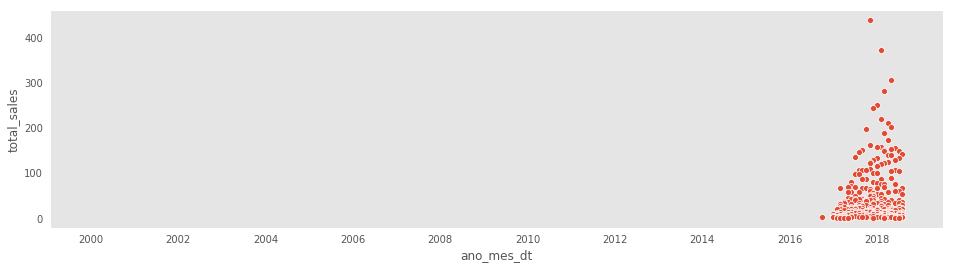

In [131]:
producto_precio=df[['product_category_name','product_id','total_price']]  
aux=producto_precio.groupby(['product_id']).agg({'total_price':'count'}).reset_index()
aux=aux.rename(columns={'total_price':'Number Products'})
aux=aux.sort_values(by='Number Products',ascending=False).head(100)
producto_principal = pd.merge(df, aux, how="inner", left_on="product_id", right_on="product_id" )
plt.figure(figsize=(16, 4))
aux=producto_principal[["product_category_name","ano_mes_dt","month_codes"]]
aux=aux.groupby(["product_category_name","ano_mes_dt","month_codes"]).size().to_frame().rename(columns={0:'total_sales'}).sort_values('total_sales', ascending=False).reset_index()
ax=sns.scatterplot(x='ano_mes_dt', y='total_sales', data=aux)
ax.grid()


In [181]:
#aux_pp=producto_principal.pivot_table(index='product_id',columns='month_codes', aggfunc=np.mean)
#aux_pp
aux_pp=producto_principal.pivot_table(values='price',index="product_id", columns="month_codes", aggfunc=np.size)

In [182]:
aux_pp

month_codes,1,3,4,5,6,7,8,9,10,11,...,13,14,15,16,17,18,19,20,21,22
product_id,,,,,,,,,,,,,,,,,,,,,
06edb72f1e0c64b14c5b79353f7abea3,NaN,NaN,NaN,NaN,NaN,1.0,3.0,8.0,4.0,2.0,...,12.0,6.0,19.0,19.0,17.0,13.0,19.0,5.0,8.0,8.0
08574b074924071f4e201e151b152b4e,NaN,NaN,NaN,6.0,3.0,20.0,8.0,10.0,7.0,9.0,...,17.0,11.0,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
0a57f7d2c983bcf8188589a5fea4a8da,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,12.0,...,1.0,19.0,13.0,6.0,2.0,5.0,18.0,9.0,NaN,NaN
0aabfb375647d9738ad0f7b4ea3653b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,24.0,9.0,...,28.0,16.0,NaN,5.0,6.0,7.0,3.0,2.0,1.0,NaN
0bcc3eeca39e1064258aa1e932269894,NaN,NaN,NaN,NaN,1.0,1.0,NaN,4.0,6.0,5.0,...,20.0,10.0,11.0,9.0,3.0,8.0,9.0,5.0,6.0,7.0
0d85c435fd60b277ffb9e9b0f88f927a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,26.0,31.0,2.0,NaN,5.0,4.0,3.0
154e7e31ebfa092203795c972e5804a6,NaN,NaN,11.0,9.0,14.0,17.0,22.0,29.0,29.0,28.0,...,28.0,19.0,19.0,17.0,8.0,NaN,7.0,3.0,3.0,2.0
165f86fe8b799a708a20ee4ba125c289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,27.0,29.0,13.0,8.0,11.0,6.0,NaN,NaN,NaN,NaN
18b0e642cbae7251e60a64aa07dd9eb9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,8.0,6.0,3.0,6.0,5.0,12.0,16.0,17.0


In [183]:
aux_pp = aux_pp.rename(columns={0:'mes_0',1:'mes_1',2:'mes_2',3:'mes_3',4:'mes_4',5:'mes_5',6:'mes_6',7:'mes_7',8:'mes_8',9:'mes_9',10:'mes_10',11:'mes_11',12:'mes_12',13:'mes_13',14:'mes_14',15:'mes_15',16:'mes_16',17:'mes_17',18:'mes_18',19:'mes_19',20:'mes_20',21:'mes_21',22:'mes_22',23:'mes_23'})
aux_pp

month_codes,mes_1,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,...,mes_13,mes_14,mes_15,mes_16,mes_17,mes_18,mes_19,mes_20,mes_21,mes_22
product_id,,,,,,,,,,,,,,,,,,,,,
06edb72f1e0c64b14c5b79353f7abea3,NaN,NaN,NaN,NaN,NaN,1.0,3.0,8.0,4.0,2.0,...,12.0,6.0,19.0,19.0,17.0,13.0,19.0,5.0,8.0,8.0
08574b074924071f4e201e151b152b4e,NaN,NaN,NaN,6.0,3.0,20.0,8.0,10.0,7.0,9.0,...,17.0,11.0,4.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
0a57f7d2c983bcf8188589a5fea4a8da,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,12.0,...,1.0,19.0,13.0,6.0,2.0,5.0,18.0,9.0,NaN,NaN
0aabfb375647d9738ad0f7b4ea3653b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,24.0,9.0,...,28.0,16.0,NaN,5.0,6.0,7.0,3.0,2.0,1.0,NaN
0bcc3eeca39e1064258aa1e932269894,NaN,NaN,NaN,NaN,1.0,1.0,NaN,4.0,6.0,5.0,...,20.0,10.0,11.0,9.0,3.0,8.0,9.0,5.0,6.0,7.0
0d85c435fd60b277ffb9e9b0f88f927a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,26.0,31.0,2.0,NaN,5.0,4.0,3.0
154e7e31ebfa092203795c972e5804a6,NaN,NaN,11.0,9.0,14.0,17.0,22.0,29.0,29.0,28.0,...,28.0,19.0,19.0,17.0,8.0,NaN,7.0,3.0,3.0,2.0
165f86fe8b799a708a20ee4ba125c289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,27.0,29.0,13.0,8.0,11.0,6.0,NaN,NaN,NaN,NaN
18b0e642cbae7251e60a64aa07dd9eb9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,8.0,6.0,3.0,6.0,5.0,12.0,16.0,17.0


In [184]:

aux_pp.dropna()

month_codes,mes_1,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,...,mes_13,mes_14,mes_15,mes_16,mes_17,mes_18,mes_19,mes_20,mes_21,mes_22
product_id,,,,,,,,,,,,,,,,,,,,,


In [173]:
#formula1 = 'mes_22~mes_20+mes_19+mes_18+mes_17+mes_16+mes_15+mes_14+mes_11+mes_10+mes_9+mes_8+mes_7+mes_6+mes_5+mes_4+mes_3+mes_1'
formula1 = 'mes_22~mes_20+mes_19+mes_18+mes_17+mes_16+mes_15+mes_14+mes_11+mes_10+mes_9+mes_8+mes_7'
model1   = sfm.ols(formula = formula1, data = aux_pp).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 mes_22   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     2044.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           0.000489
Time:                        04:32:56   Log-Likelihood:                -15.727
No. Observations:                  13   AIC:                             53.45
Df Residuals:                       2   BIC:                             59.67
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9989      2.389     -0.418      0.7

### Estimando la correlación

Medimos la relación lineal entre las ventas totales y el mes, calculamos la matriz de correlacion para determinar la influencia de la variable:

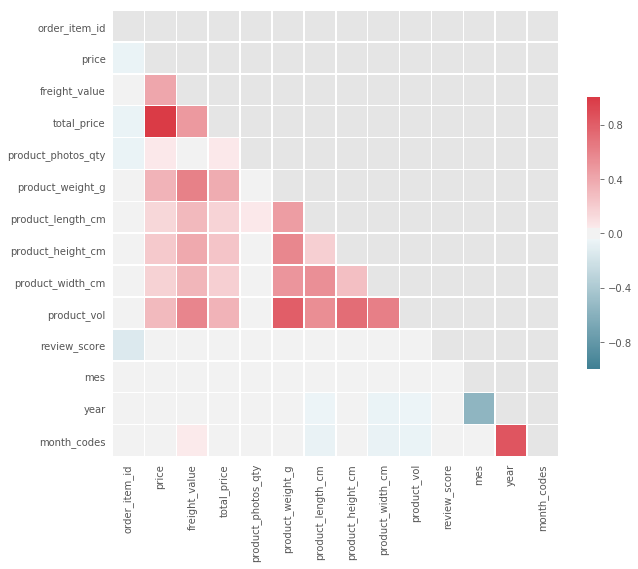

In [43]:
#compute correlation matrix
df_correlations = df.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

In [44]:
df

,order_id,customer_id,order_purchase_timestamp,order_status,customer_city,customer_state,order_item_id,product_id,price,freight_value,...,product_vol,review_score,ano_mes,ano_mes_dt,fecha,mes,year,month_codes,name_state,regions
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,delivered,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,...,1976.0,4,2017-10,2017-10-01,2017-10-02 10:56:33,10,2017,12,São Paulo,Sudeste
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,delivered,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,...,4693.0,4,2018-07,2018-07-01,2018-07-24 20:41:37,7,2018,21,Bahía,Nordeste
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,delivered,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,...,9576.0,5,2018-08,2018-08-01,2018-08-08 08:38:49,8,2018,22,Goiás,CentroOeste
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,delivered,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,...,6000.0,5,2017-11,2017-11-01,2017-11-18 19:28:06,11,2017,13,Río Grande del Norte,Nordeste
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,delivered,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,...,11475.0,5,2018-02,2018-02-01,2018-02-13 21:18:39,2,2018,16,São Paulo,Sudeste
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05,delivered,congonhinhas,PR,1.0,060cb19345d90064d1015407193c233d,147.90,27.36,...,42250.0,4,2017-07,2017-07-01,2017-07-09 21:57:05,7,2017,9,Paraná,Sur
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,2017-04-11 12:22:08,invoiced,santa rosa,RS,1.0,a1804276d9941ac0733cfd409f5206eb,49.90,16.05,...,18375.0,2,2017-04,2017-04-01,2017-04-11 12:22:08,4,2017,6,Río Grande del Sur,Sur
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-16 13:10:30,delivered,nilopolis,RJ,1.0,4520766ec412348b8d4caa5e8a18c464,59.99,15.17,...,4352.0,5,2017-05,2017-05-01,2017-05-16 13:10:30,5,2017,7,Río de Janeiro,Sudeste
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,2017-01-23 18:29:09,delivered,faxinalzinho,RS,1.0,ac1789e492dcd698c5c10b97a671243a,19.90,16.05,...,18375.0,1,2017-01,2017-01-01,2017-01-23 18:29:09,1,2017,3,Río Grande del Sur,Sur
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,2017-07-29 11:55:02,delivered,sorocaba,SP,1.0,9a78fb9862b10749a117f7fc3c31f051,149.99,19.77,...,72324.0,5,2017-07,2017-07-01,2017-07-29 11:55:02,7,2017,9,São Paulo,Sudeste


In [15]:
corr_mat  = df[['total_sales','codes']].corr()
corr_mat[['total_sales','codes']][0:1]

,total_sales,codes
total_sales,1.0,0.521102


### Grafica de la relación lineal

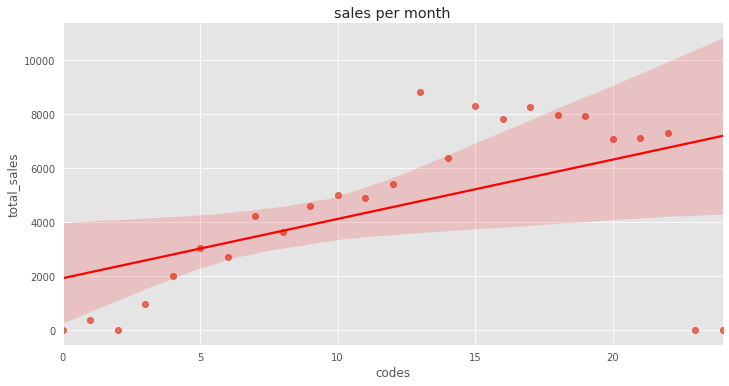

In [16]:
# relación lineal entre las ventas totales y el mes
sns.lmplot(x='codes',y='total_sales',data=aux,line_kws = {'color': "red"} ,aspect= 2)
plt.title('sales per month');

### Modelo

In [17]:
formula = 'total_sales~codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     8.574
Date:                Wed, 16 Dec 2020   Prob (F-statistic):            0.00756
Time:                        13:00:35   Log-Likelihood:                -232.02
No. Observations:                  25   AIC:                             468.0
Df Residuals:                      23   BIC:                             470.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1926.0215   1051.071      1.832      0.0

In [18]:
# predict
X = sm.add_constant(aux["codes"][:1])
model.predict(X)

0    4783.831538
dtype: float64

# Sales of a product per month

### Data Exploration
Generamos una grafica de las ventas por mes de un producto 

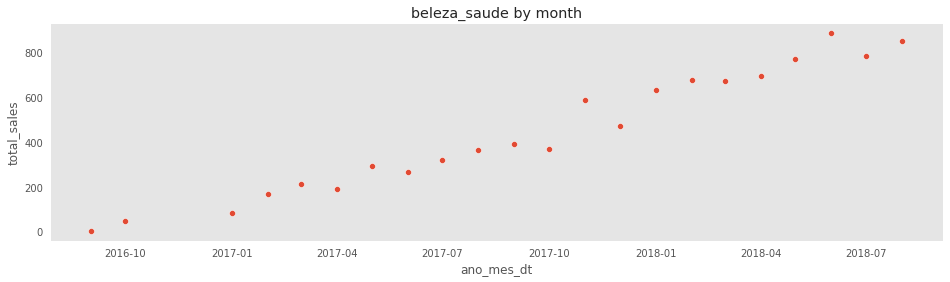

In [19]:
item=2
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","ano_mes_dt","codes"]]
aux=aux.groupby(["product_category_name","ano_mes_dt","codes"]).size().to_frame().rename(columns={0:'total_sales'}).sort_values('total_sales', ascending=False).reset_index()
listaP=list(aux["product_category_name"])
aux=aux[(aux["product_category_name"]==listaP[item])]
ax=sns.scatterplot(x='ano_mes_dt', y='total_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title(listaP[item]+' by month')
ax.grid()

### Correlación

Medimos la relación lineal entre las variables, calculamos la matriz de correlacion para determinar la influencia de las variables :

In [20]:
corr_mat  = aux[['total_sales','codes']].corr()
corr_mat

,total_sales,codes
total_sales,1.000000,0.984842
codes,0.984842,1.000000


### Grafica de la relación lineal

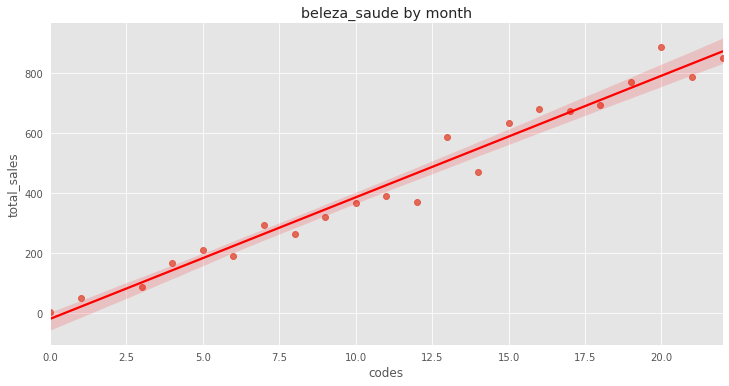

In [21]:
# relación lineal entre las ventas totales y el mes
sns.lmplot(x='codes',y='total_sales',data=aux,line_kws = {'color': "red"} ,aspect= 2)
plt.title(listaP[item]+' by month');

### Modelo

In [22]:
formula = 'total_sales~codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     644.8
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.09e-16
Time:                        13:00:36   Log-Likelihood:                -115.60
No. Observations:                  22   AIC:                             235.2
Df Residuals:                      20   BIC:                             237.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.9722     20.941     -0.954      0.3

In [23]:
# predict
X = sm.add_constant(aux["codes"][:1])
model.predict(X)

2    790.178276
dtype: float64

# Total product sales by region
### Data Exploration
The dataframe has 74 product categories, we generate a graph with the amount of products sold by region and we organize it in descending order.

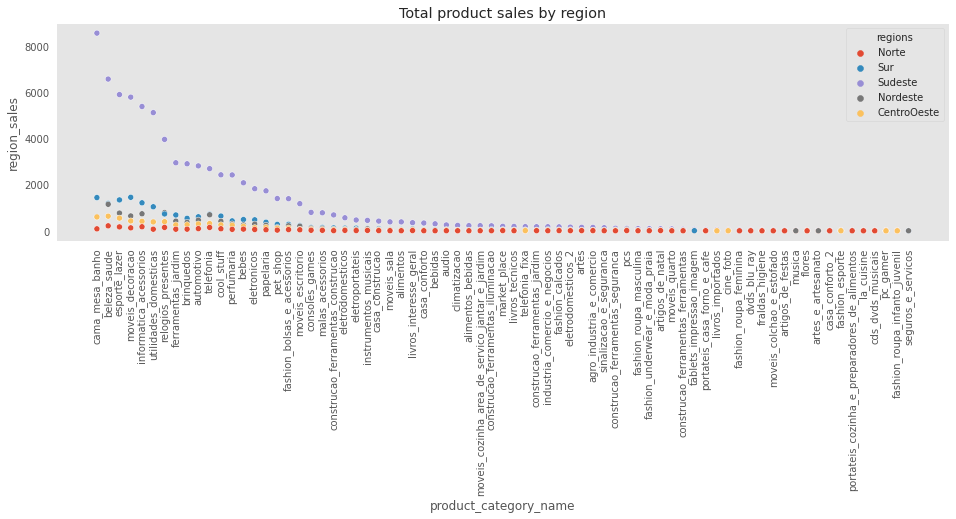

In [24]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","regions"]]
aux=aux.groupby(["product_category_name","regions"]).size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
ax=sns.scatterplot(x='product_category_name', y='region_sales', hue='regions', data=aux)
plt.xticks(rotation=90)
ax.set_title('Total product sales by region')
ax.grid()

### Correlación

Existen factores que podrian impulsar la venta de algunos productos. Seleccionamos algunas variables y medimos la relación lineal entre estas variables y el total de ventas de producto por region usando la correlacion, calculamos la matriz de correlacion para determinar su influencia: 

In [25]:
print('correlacion de total ventas por region\n')
print('Region   ','price   ', 'freight_value', 'product_photos','review_score','Region',sep='\t')
for R in region:
    aux=df[(df['regions']==R)][['product_category_name','price', 'freight_value', 'product_photos_qty','review_score','regions','order_purchase_timestamp']]
    aux2=aux.groupby('product_category_name').size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
    aux=pd.merge(aux, aux2, how="left", left_on="product_category_name", right_on="product_category_name")
    corr_mat  = aux[['region_sales','price', 'freight_value', 'product_photos_qty','review_score']].corr()
    
    corr_list = corr_mat[['price', 'freight_value', 'product_photos_qty','review_score']][0:1].values.tolist()[0]
    print ('region_sales',round(corr_list[0],6),round(corr_list[1],6),round(corr_list[2],6),round(corr_list[3],6),R,sep='\t')

correlacion de total ventas por region

Region   	price   	freight_value	product_photos	review_score	Region
region_sales	0.007108	-0.082618	-0.063886	-0.045361	Norte
region_sales	-0.087326	-0.071675	-0.112353	-0.041409	Sur
region_sales	-0.071326	-0.058666	-0.14764	-0.02558	Sudeste
region_sales	-0.01816	-0.103161	-0.039489	-0.000758	Nordeste
region_sales	-0.065486	-0.102623	-0.145577	-0.007217	CentroOeste


### Modelo

In [26]:
formula = 'region_sales~price+review_score+freight_value+product_photos_qty'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           region_sales   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     52.65
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           9.98e-44
Time:                        13:00:39   Log-Likelihood:                -43737.
No. Observations:                6567   AIC:                         8.748e+04
Df Residuals:                    6562   BIC:                         8.752e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            408.5216      8

# Sale of one item in the region per month

### Data Exploration

relogios_presentes per month in the region Sudeste


,ano_mes_dt,codes,region_sales,price,freight_value,product_photos_qty,review_score
29873,2016-10-01,1,1,29.9,15.56,3.0,4
29872,2016-10-01,1,1,633.0,20.39,2.0,5
29871,2016-10-01,1,1,1399.0,24.55,3.0,5
29796,2017-01-01,3,1,149.0,15.21,2.0,5
29798,2017-01-01,3,1,222.4,18.00,1.0,5
...,...,...,...,...,...,...,...
22320,2018-08-01,22,1,719.9,23.14,1.0,5
22321,2018-08-01,22,1,798.0,21.78,1.0,5
22322,2018-08-01,22,1,799.0,20.69,4.0,5
22311,2018-08-01,22,1,350.0,11.20,1.0,5


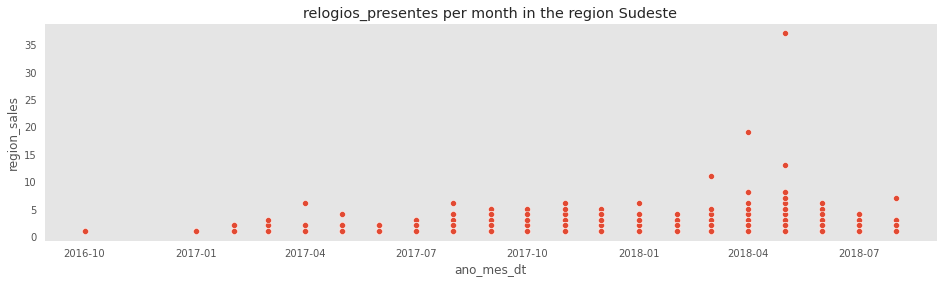

In [102]:
item=0
R='Sudeste'
plt.figure(figsize=(16, 4))
aux=df[(df['regions']==R)][['product_category_name',"ano_mes_dt","codes",'price', 'freight_value', 'product_photos_qty','review_score','regions']]
aux=aux.groupby(['product_category_name',"ano_mes_dt","codes",'price', 'freight_value', 'product_photos_qty','review_score']).size().to_frame().rename(columns={0:'region_sales'}).sort_values('region_sales', ascending=False).reset_index()
listaP=list(aux["product_category_name"].unique())
aux=aux[(aux["product_category_name"]==listaP[item])][["ano_mes_dt","codes",'region_sales','price', 'freight_value', 'product_photos_qty','review_score']].sort_values('ano_mes_dt', ascending=True)
ax=sns.scatterplot(x='ano_mes_dt', y='region_sales', data=aux)
#plt.xticks(rotation=90)
ax.set_title(listaP[item]+' per month in the region '+R)
ax.grid()
print(listaP[item]+' per month in the region',R)
aux

### Correlación

In [110]:
print('Correlacion de total ventas de',listaP[item],'por mes en la region',R,'\n')
corr_mat  = aux[['region_sales','price', 'freight_value', 'product_photos_qty','review_score','codes']].corr()
corr_mat#[['region_sales','price', 'freight_value', 'product_photos_qty','review_score','codes']][0:1]

Correlacion de total ventas de relogios_presentes por mes en la region Sudeste 



,region_sales,price,freight_value,product_photos_qty,review_score,codes
region_sales,1.000000,-0.069877,-0.103909,-0.006948,0.048125,0.029607
price,-0.069877,1.000000,0.360795,-0.171714,0.043730,-0.092204
freight_value,-0.103909,0.360795,1.000000,-0.170318,0.001638,-0.004938
product_photos_qty,-0.006948,-0.171714,-0.170318,1.000000,-0.068723,-0.008770
review_score,0.048125,0.043730,0.001638,-0.068723,1.000000,-0.032746
codes,0.029607,-0.092204,-0.004938,-0.008770,-0.032746,1.000000


### Modelo

In [107]:
formula = 'region_sales~price+review_score+freight_value+product_photos_qty+codes'
model   = sfm.ols(formula = formula, data = aux).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           region_sales   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.44
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           5.93e-10
Time:                        14:23:53   Log-Likelihood:                -4555.3
No. Observations:                3237   AIC:                             9123.
Df Residuals:                    3231   BIC:                             9159.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.2590      0

# OTRAS GRAFICAS

## Purchases by state

We generate a graph with the amount of online purchases made in each state

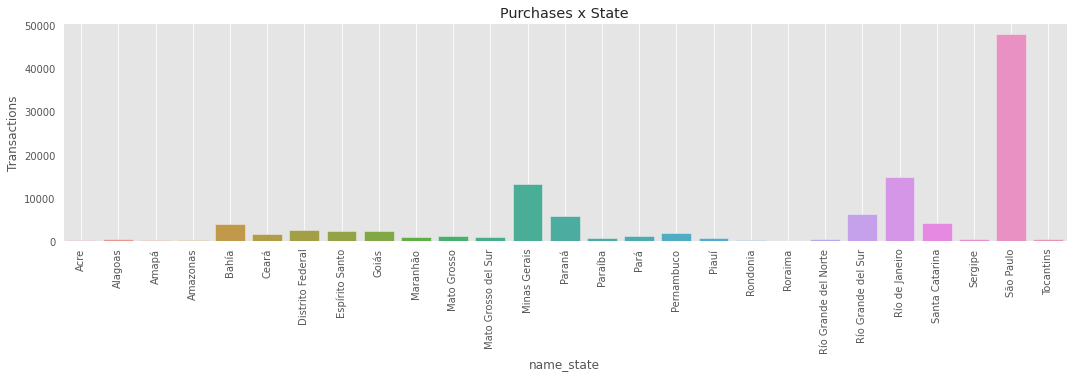

In [27]:
plt.figure(figsize=(18, 4))
aux=df.groupby('name_state').size().to_frame().rename(columns={0:'Transactions'}).head(27).reset_index()
ax=sns.barplot(x='name_state',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Purchases x State')
ax.grid()

The states that make the most purchases are Sao Pablo and Rio de Janeiro, the two main states in the country.

## Most selled products

The dataframe has 74 categories of products, we generate a graph with the amount of products sold by category and organize it descendingly.

The dataframe has  74  categories of products


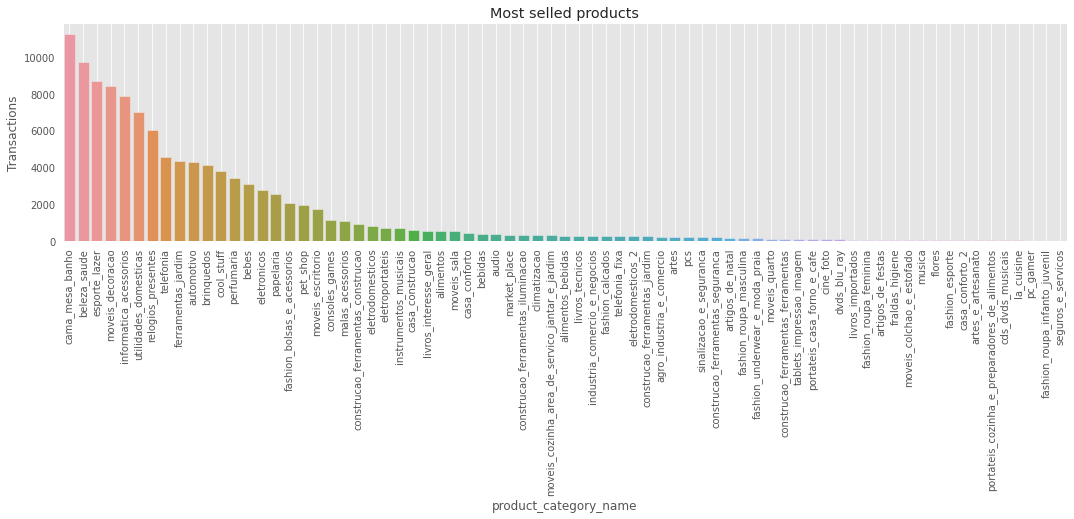

In [28]:
plt.figure(figsize=(18, 4))
aux=df.groupby('product_category_name').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(74).reset_index()
listaP=list(aux["product_category_name"])
ax=sns.barplot(x='product_category_name',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Most selled products')
ax.grid()
print("The dataframe has ",len(df['product_category_name'].unique())," categories of products")

## Cities with the highest number of sales

The dataframe has 4119 cities, we take the 50 cities that have the most registered sales, and we generate a graph with the number of sales per city, organized in descending order.

We have 4119 cities, the 50 that register the highest number of sales are shown


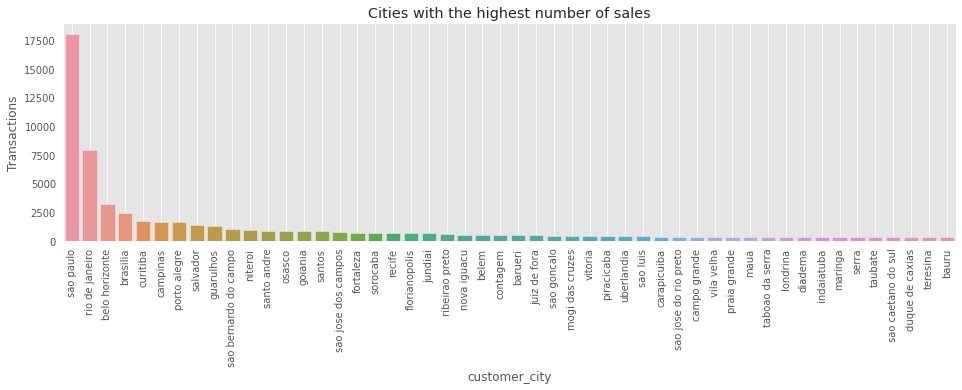

In [29]:
plt.figure(figsize=(16, 4))
aux=df.groupby('customer_city').size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).head(50).reset_index()
listaC=list(aux["customer_city"])
ax=sns.barplot(x='customer_city',y='Transactions',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Cities with the highest number of sales')
ax.grid()
print("We have", len(df["customer_city"].unique()),"cities, the 50 that register the highest number of sales are shown")

## Best-selling products by city

The dataframe has 74 product categories, we generate a graph with the amount of products sold by city and we organize it in descending order, we take the 10 cities that register the highest number of sales.

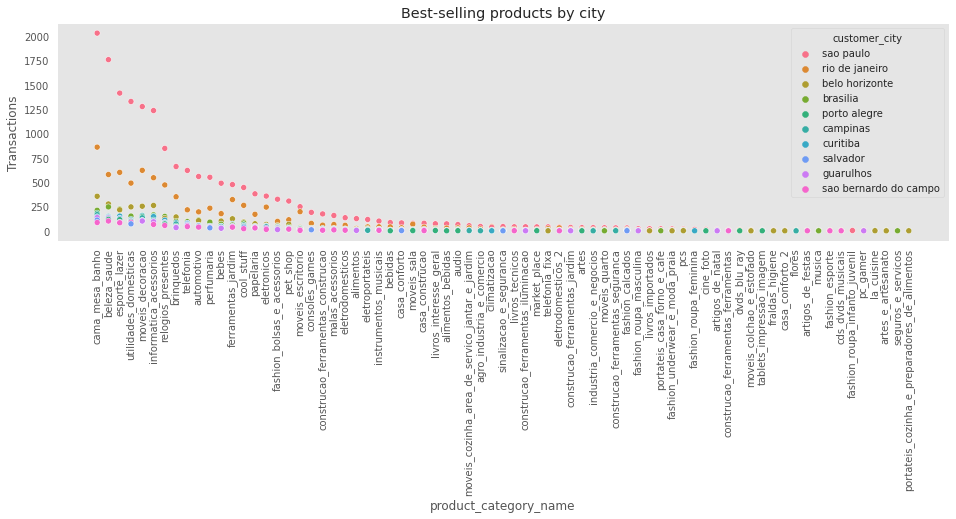

In [30]:
listaC2=listaC[:10]
plt.figure(figsize=(16, 4))
aux=df[(df["customer_city"].isin(listaC2))][["product_category_name","customer_city"]]
aux=aux.groupby(["product_category_name","customer_city"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='Number de transaciones', hue='customer_city', data=aux)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='customer_city', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by city')
ax.grid()

## Best-selling products by state

The dataframe has 74 product categories, we generate a graph with the amount of products sold by state and we organize it in descending order.

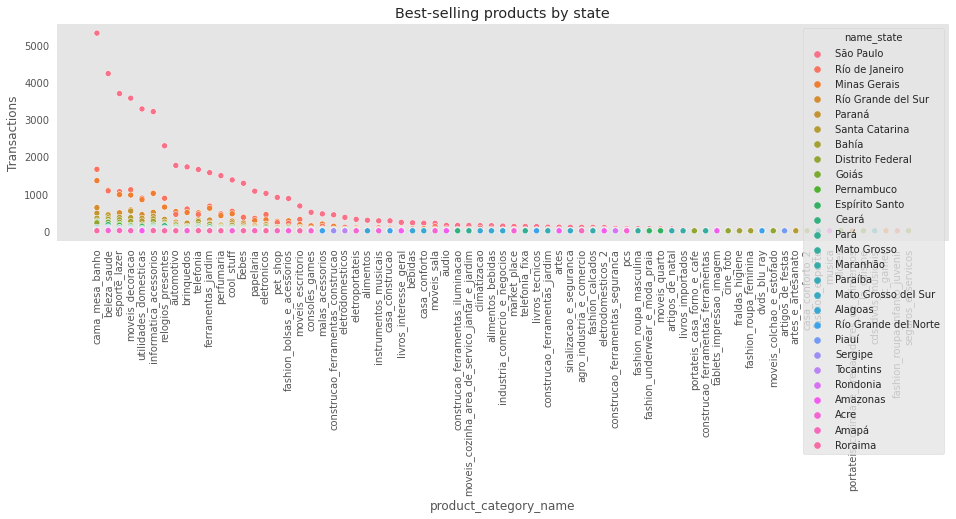

In [31]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","name_state"]]
aux=aux.groupby(["product_category_name","name_state"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux=aux.sort_values('Transactions', ascending=False)
#aux=aux[:50]
#ax=sns.lineplot(x='product_category_name', y='Number de transaciones', hue='customer_city', data=aux)
ax=sns.scatterplot(x='product_category_name', y='Transactions', hue='name_state', data=aux)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by state')
ax.grid()

# Review score by product

The dataframe has 74 product categories, we generate a graph with the amount of estrellas por producto in descending order.

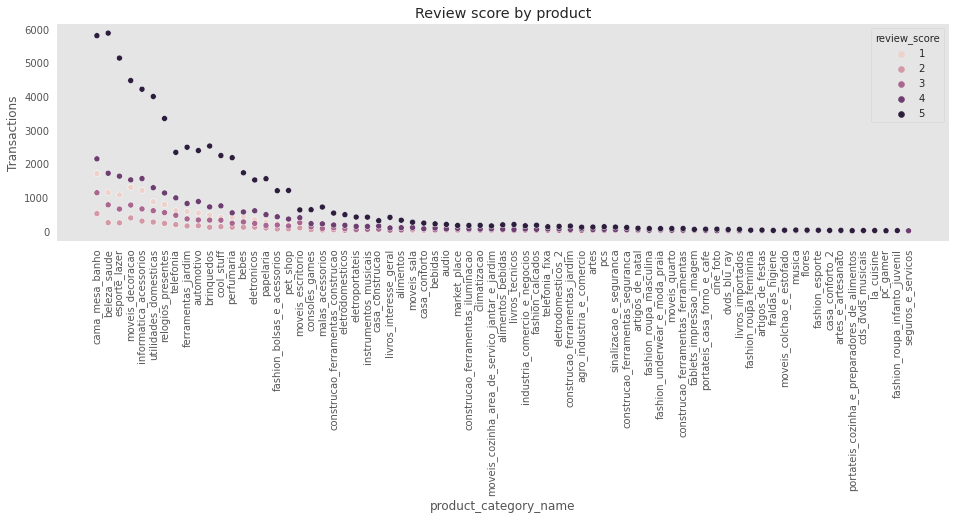

In [32]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","review_score"]]
aux=aux.groupby(["product_category_name","review_score"]).size().to_frame().rename(columns={0:'Transactions'}).reset_index()
aux.product_category_name  = aux.product_category_name .astype(pd.api.types.CategoricalDtype(categories=listaP, ordered = True))
#aux=aux[aux["product_category_name"].isin(listaP[:10])]
#ax=sns.boxplot(x='product_category_name',y='Transactions',hue='review_score', data=aux)#.set_yscale('log')
ax=sns.scatterplot(x='product_category_name',y='Transactions',hue='review_score',data=aux);
plt.xticks(rotation=90);
ax.set_title('Review score by product')
ax.grid()

# Best-selling products by month

The dataframe has 74 product categories, we generate a graph with the amount of estrellas por producto in descending order

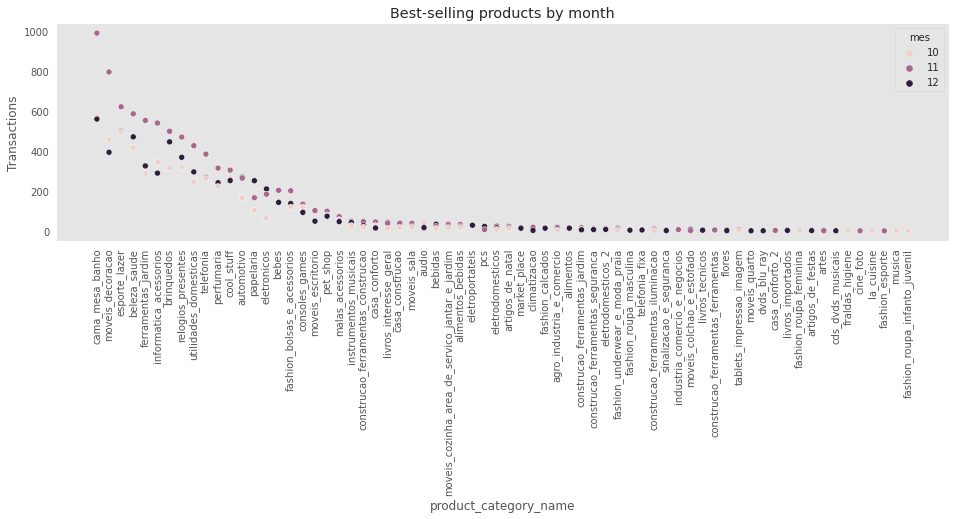

In [33]:
plt.figure(figsize=(16, 4))
aux=df[["product_category_name","mes"]]
aux2=aux[(aux["mes"]>9)]
aux2=aux2.groupby(["product_category_name","mes"]).size().to_frame().rename(columns={0:'Transactions'}).sort_values('Transactions', ascending=False).reset_index()
#aux2=aux2[(aux2["Transactions"]>10)]
ax=sns.scatterplot(x='product_category_name', y='Transactions',hue="mes", data=aux2)
plt.xticks(rotation=90)
ax.set_title('Best-selling products by month')
ax.grid()

# FIN XIMENA

# Highest Income per Category

In [34]:
a=pd.merge(order_items, orders, on=['order_id'])
merged_df=pd.merge(a, products, on=['product_id'])

In [35]:
merged_df.order_status.value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [36]:
top50categories_df=merged_df['price'].groupby(merged_df['product_category_name']).sum().sort_values(ascending=False)[:50]
top50categories_df

product_category_name
beleza_saude                                      1258681.34
relogios_presentes                                1205005.68
cama_mesa_banho                                   1036988.68
esporte_lazer                                      988048.97
informatica_acessorios                             911954.32
moveis_decoracao                                   729762.49
cool_stuff                                         635290.85
utilidades_domesticas                              632248.66
automotivo                                         592720.11
ferramentas_jardim                                 485256.46
brinquedos                                         483946.60
bebes                                              411764.89
perfumaria                                         399124.87
telefonia                                          323667.53
moveis_escritorio                                  273960.70
papelaria                                          230943.23
pc

Text(0, 0.5, 'Product Category')

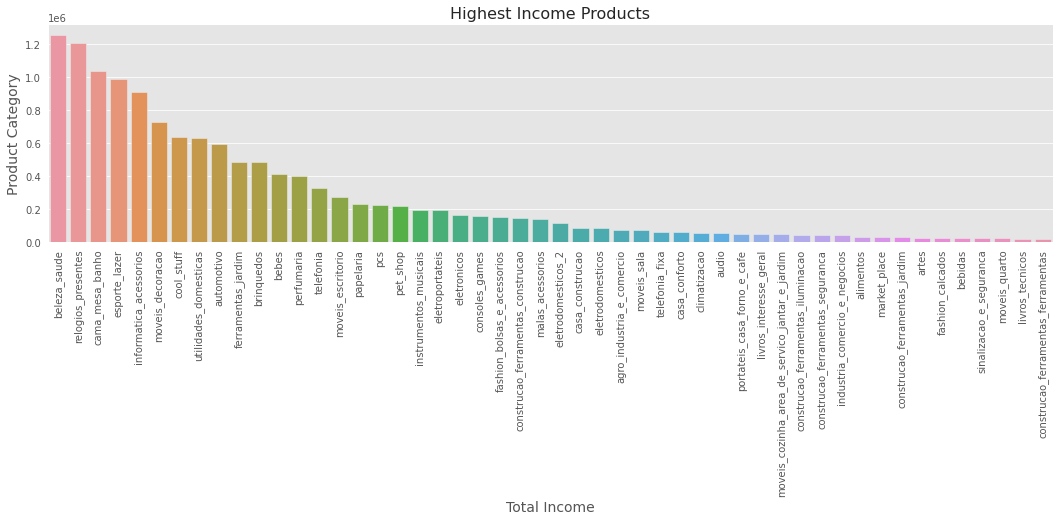

In [37]:
fig=plt.figure(figsize=(18,4))
sns.barplot(y=top50categories_df.values,x=top50categories_df.index)
plt.title('Highest Income Products',fontsize=16)
plt.xlabel('Total Income',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Product Category',fontsize=14)

It's interesting looking at this chart that the highest incomes for the platform come from the category health, beauty.

# Late Deliveries

In [38]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
estimated_time = pd.to_datetime(merged_df.order_estimated_delivery_date)
merged_df["late_delivery"] = delivered_time - estimated_time
merged_df["late_delivery"]=merged_df["late_delivery"]/np.timedelta64(1,"D")

In [39]:
late_deliveries_df = merged_df[merged_df.late_delivery > 0]
late_deliveries_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
5,cool_stuff,2017-08-31 20:19:52,2017-08-24 00:00:00,7.847130
16,ferramentas_jardim,2018-04-02 22:32:10,2018-03-23 00:00:00,10.939005
29,utilidades_domesticas,2017-07-10 11:46:40,2017-07-10 00:00:00,0.490741
36,beleza_saude,2018-03-29 18:17:31,2018-03-29 00:00:00,0.762164
68,beleza_saude,2018-05-23 17:51:15,2018-05-16 00:00:00,7.743924
69,beleza_saude,2018-05-23 17:51:15,2018-05-16 00:00:00,7.743924
71,beleza_saude,2018-02-24 16:26:53,2018-02-21 00:00:00,3.685336
97,fashion_bolsas_e_acessorios,2018-08-07 13:56:52,2018-08-07 00:00:00,0.581157
120,cama_mesa_banho,2017-09-04 13:34:13,2017-08-31 00:00:00,4.565428
121,cama_mesa_banho,2018-03-29 23:42:46,2018-03-16 00:00:00,13.988032


# Difference between Delivered Time and Delivered Estimated Time vs Reviews

In [40]:
delivered_time = pd.to_datetime(merged_df.order_delivered_customer_date)
approved_time = pd.to_datetime(merged_df.order_approved_at)
merged_df["delivery_time"] = delivered_time - approved_time
merged_df["delivery_time"] = merged_df["delivery_time"]/np.timedelta64(1,"D")

In [41]:
delivery_time_df = merged_df[merged_df.delivery_time > 0]
delivery_time_df[["product_category_name", "order_delivered_customer_date", "order_estimated_delivery_date", "late_delivery"]].head(10)

,product_category_name,order_delivered_customer_date,order_estimated_delivery_date,late_delivery
0,cool_stuff,2017-09-20 23:43:48,2017-09-29 00:00:00,-8.011250
1,cool_stuff,2017-07-13 20:39:29,2017-07-26 00:00:00,-12.139248
2,cool_stuff,2018-06-04 18:34:26,2018-06-07 00:00:00,-2.226088
3,cool_stuff,2017-08-09 21:26:33,2017-08-25 00:00:00,-15.106563
4,cool_stuff,2017-08-24 20:04:21,2017-09-01 00:00:00,-7.163646
5,cool_stuff,2017-08-31 20:19:52,2017-08-24 00:00:00,7.847130
6,cool_stuff,2018-03-28 21:57:44,2018-04-12 00:00:00,-14.084907
7,cool_stuff,2017-08-14 18:13:03,2017-09-06 00:00:00,-22.240938
8,cool_stuff,2017-06-26 13:52:03,2017-07-06 00:00:00,-9.422187
9,pet_shop,2017-05-12 16:04:24,2017-05-15 00:00:00,-2.330278


In [42]:
orders1 = orders.copy()
orders1 = orders1[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
orders1['order_delivered_customer_date'] = pd.to_datetime(orders1['order_delivered_customer_date'])
orders1['order_estimated_delivery_date'] = pd.to_datetime(orders1['order_estimated_delivery_date'])
orders1['Estimated_Delivered'] = orders1['order_delivered_customer_date']-orders1['order_estimated_delivery_date']
orders1['Estimated_Delivered'] = orders1['Estimated_Delivered'].dt.days
orders1.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0


Here we calculate the delta between Estimated Delivery date versus the real time the costumer delivered time

In [43]:
orders_reviews = pd.merge(orders1, reviews, on="order_id", how="left")
orders_reviews = orders_reviews[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'Estimated_Delivered', 'review_score']]
orders_reviews['Puntuality'] = np.where(orders_reviews['Estimated_Delivered'] <= 0, "Punctual", "Unpunctual")
orders_reviews.head()

,order_id,order_delivered_customer_date,order_estimated_delivery_date,Estimated_Delivered,review_score,Puntuality
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-10 21:25:13,2017-10-18,-8.0,4,Punctual
1,53cdb2fc8bc7dce0b6741e2150273451,2018-08-07 15:27:45,2018-08-13,-6.0,4,Punctual
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-17 18:06:29,2018-09-04,-18.0,5,Punctual
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-02 00:28:42,2017-12-15,-13.0,5,Punctual
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-16 18:17:02,2018-02-26,-10.0,5,Punctual


Now, we make cathegorical variables by the reviews scores as punctual or unpunctual by the difference between Estimated Delivery and Real Delivery. When this delta is negative or zero, we classify it as "Punctual" because the company accomplish his terms of service, else the variable takes the "Unpunctual" value

In [44]:
x_review_punctual = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality'])
x_review_punctual

Puntuality,Punctual,Unpunctual
review_score,,
1,6205,5653
2,2442,793
3,7345,942
4,18382,818
5,56076,1344


Here we can see the count by Puntuality and the review scores. Scannig the table, we realize that there is a inverse correlation between the score of the review and the puntuality of the delivery. This relationship is inverse. When the company is punctual in his delivery, then the costumer tends to make a good review with a good score and viceversa.

In [45]:
x_review_punctual_p = pd.crosstab(orders_reviews['review_score'], orders_reviews['Puntuality']).apply(lambda r: r*100/len(orders_reviews), axis=1)
x_review_punctual_p.reset_index
x_review_punctual_p

Puntuality,Punctual,Unpunctual
review_score,,
1,6.205,5.653
2,2.442,0.793
3,7.345,0.942
4,18.382,0.818
5,56.076,1.344


Here we see the table by percentages

<AxesSubplot:xlabel='review_score'>

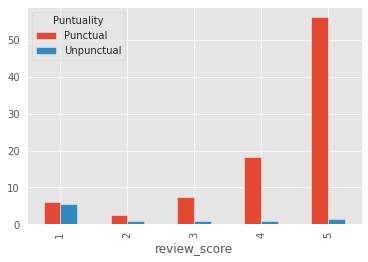

In [46]:
x_review_punctual_p.plot(kind="bar")
#x_review_punctual_p.plot(kind="line")

---

# Purchasing trend by hour or day of the week 

In [47]:
#unifying the variables in one data frame
orders_by_date = pd.merge(left = orders , right = order_payments , how='left', left_on='order_id', right_on='order_id')
orders_by_date.head() 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12


In [48]:
#Elimitating columns we dont need yet
orders_by_date = orders_by_date.drop(['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','payment_sequential', 'payment_type', 'payment_installments'], axis=1)

In [49]:
#validation of any null values in the order_payment data frame to use
orders_by_date.isnull().any()

order_id                    False
customer_id                 False
order_status                False
order_purchase_timestamp    False
payment_value                True
dtype: bool

In [50]:
#Elimitating nulls
orders_by_date = orders_by_date.dropna()
orders_by_date = orders_by_date.reset_index(drop=True)
orders_by_date

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


In [51]:
orders_by_date.isnull().any()

order_id                    False
customer_id                 False
order_status                False
order_purchase_timestamp    False
payment_value               False
dtype: bool

In [52]:
#First we need to change the format of the column DATE to datetime:
orders_by_date['order_purchase_timestamp'] = pd.to_datetime(orders_by_date['order_purchase_timestamp'])
orders_by_date

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,441.16


<AxesSubplot:xlabel='order_purchase_timestamp'>

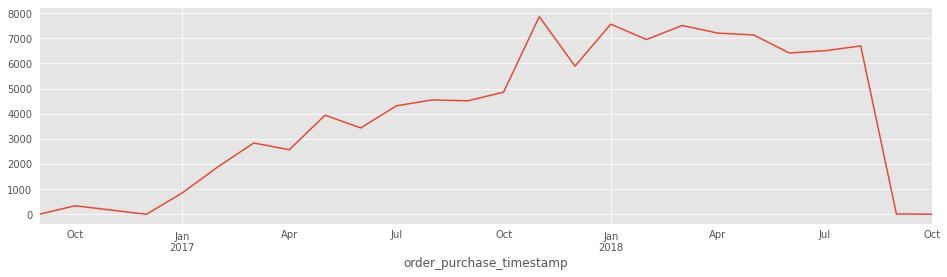

In [53]:
#Then, check whether the number of orders has increased over time
plt.figure(figsize=(16, 4))
monthly_payments = orders_by_date.groupby(orders_by_date['order_purchase_timestamp'].dt.to_period('M')).size()
monthly_payments.plot.line()

As shown in the graph, the number of orders has been increasing over the 2017, till around November-December 2017 where we can see a decreasing, and around January 2018 continue fluctuating but increasing till October when the data end.

<AxesSubplot:xlabel='order_purchase_timestamp'>

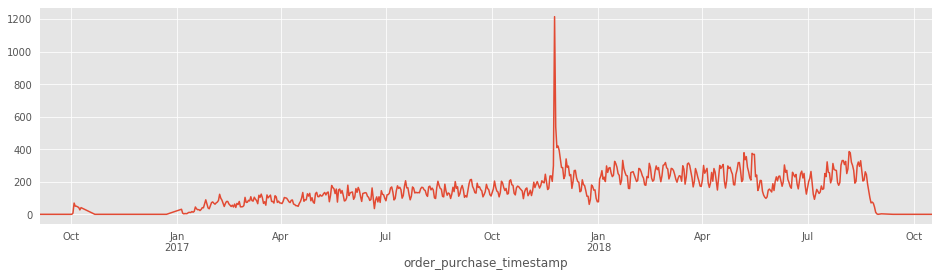

In [54]:
#Then, check whether the number of orders has increased over time
plt.figure(figsize=(16, 4))
Daily_payments = orders_by_date.groupby(orders_by_date['order_purchase_timestamp'].dt.to_period('D')).size()
Daily_payments.plot.line()

If we see the graph daily we can see how and the end of November 2017 the number of orders increased significative for some days and later decreasing, we are evaluating the event that took place those days to see the variability of the values.


In [55]:
#Adding the days to the Data frame
orders_by_date["NAME_WEEKDAY"] = orders_by_date['order_purchase_timestamp'].dt.day_name()

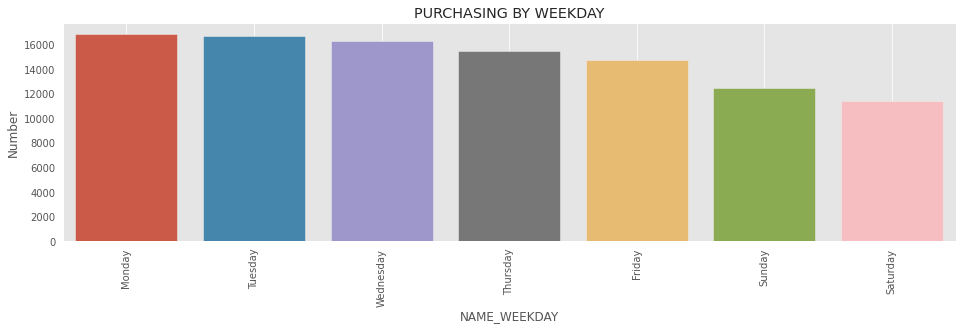

In [56]:
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("NAME_WEEKDAY").size().to_frame().rename(columns={0:'Number'}).sort_values("NAME_WEEKDAY", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["NAME_WEEKDAY"])
ax=sns.barplot(x="NAME_WEEKDAY",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY WEEKDAY')
ax.grid()

When we evaluate the number of purchases per week we can see how, during the week, the largest number of purchases is found on Mondays followed closely with the other days of the week and lastly we find the weekends, with Saturday being the day with the least amount of purchases.

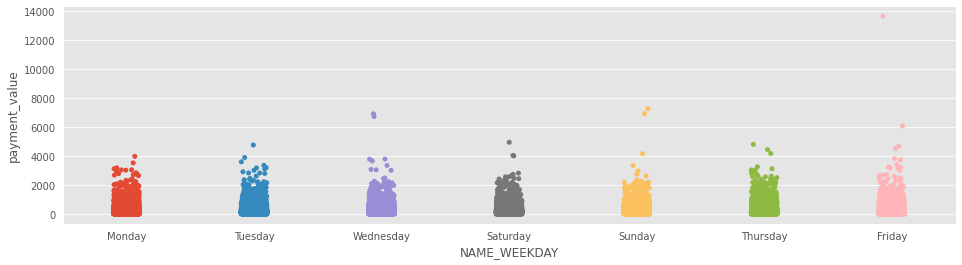

In [57]:
plt.figure(figsize=(16, 4))
ax = sns.stripplot(x="NAME_WEEKDAY", y="payment_value", data = orders_by_date)
plt.ylabel('payment_value')
plt.show()

As shown in the graph, the sales values are more or less grouped below 3000, only a few values exceeded 3000 and are located below 6000, another four sales above 8000 and a single one per ma of 13000 reais.

In [58]:
#Adding the hours to the Data frame
orders_by_date["order_purchase_hour"] = orders_by_date['order_purchase_timestamp'].dt.hour

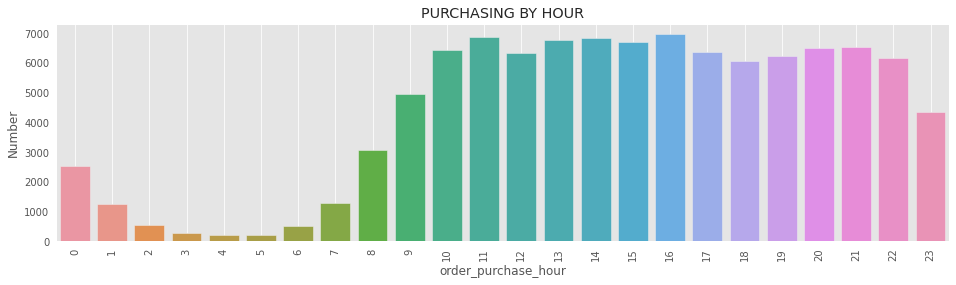

In [59]:
plt.figure(figsize=(16, 4))
aux= orders_by_date.groupby("order_purchase_hour").size().to_frame().rename(columns={0:'Number'}).sort_values("order_purchase_hour", ascending=False).sort_values('Number', ascending=False).reset_index()
listaC=list(aux["order_purchase_hour"])
ax=sns.barplot(x="order_purchase_hour",y='Number',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('PURCHASING BY HOUR')
ax.grid()

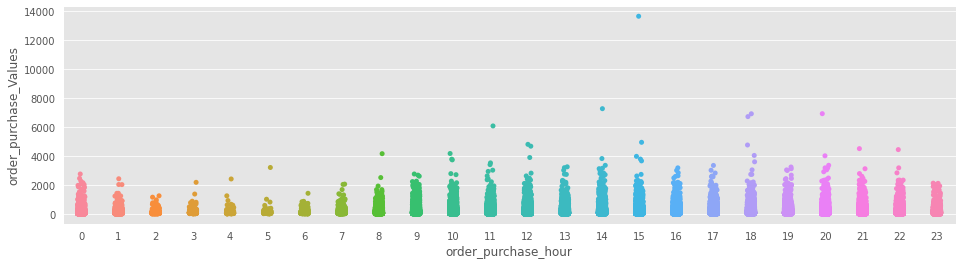

In [60]:
plt.figure(figsize=(16, 4))
bx = sns.stripplot(x="order_purchase_hour", y="payment_value", data = orders_by_date)
plt.ylabel('order_purchase_Values')
plt.show()


Here in the Stripplox we can see a better look of how the purchasings are accumulated over the hours with more of the values around 3000 and less over the 3000 and 9000 and just one value below the 14000.

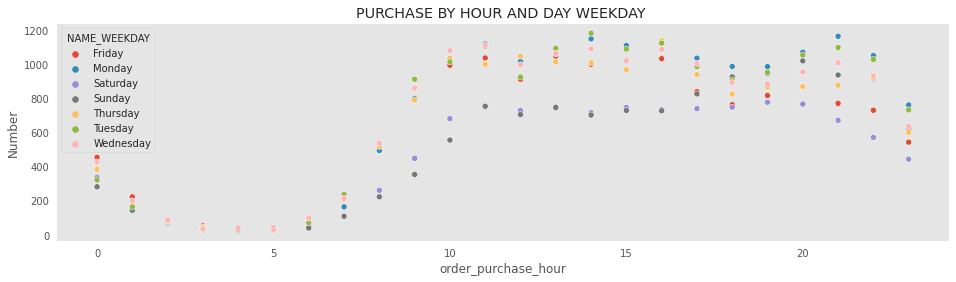

In [61]:
plt.figure(figsize=(16, 4))
aux = orders_by_date[["order_purchase_hour","NAME_WEEKDAY"]]
aux = aux.groupby(["order_purchase_hour","NAME_WEEKDAY"]).size().to_frame().rename(columns={0:'Number'}).reset_index()
#aux = aux.sort_values('Number', ascending=False)
#aux=aux[:50]
ax=sns.scatterplot(x="order_purchase_hour", y='Number', hue="NAME_WEEKDAY", data=aux)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('PURCHASE BY HOUR AND DAY WEEKDAY ')
ax.grid()


Here we can see the relation between the day of the week and the purchase hour, we can observe how is the behavior.

In [62]:
orders_by_date.pivot_table("payment_value","order_purchase_hour", aggfunc=np.sum)

,payment_value
order_purchase_hour,
0,374429.87
1,175968.42
2,66206.97
3,41914.04
4,28583.21
5,26216.23
6,67684.37
7,182607.59
8,463172.92


We did a pivot to see the total value of all purchasing  by each hour and by date below.

In [63]:
orders_by_date.pivot_table("payment_value","NAME_WEEKDAY", aggfunc=np.sum)


,payment_value
NAME_WEEKDAY,
Friday,2307128.20
Monday,2622457.97
Saturday,1768427.68
Sunday,1872456.36
Thursday,2384544.22
Tuesday,2560743.03
Wednesday,2493114.66


Purchasing by date below.

# Payment type trends 

In [64]:
efective_orders=orders[(orders.order_status!= 'canceled') & (orders.order_status!= 'unavailable')]

In [65]:
#payment_orders= pd.concat([order_payments,efective_orders], axis=1)
payment_orders=pd.merge(order_payments, efective_orders)

In [66]:
import datetime
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in payment_orders['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
payment_orders['Month']=timesMonth
payment_orders['Year']=timesYear
payment_orders['WeekDay']=weekday
payment_orders['Hour']=hour
payment_orders.head()
# pd.datetime.now().year*100+pd.datetime.now().month

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Month,Year,WeekDay,Hour
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,4,2018,2,22
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,6,2018,1,11
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,12,2017,1,11
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,12,2017,2,12
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,5,2018,0,13


#### Most people in Brazil E Commerce use Credit Card  to pay their buys

/home/ximena/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


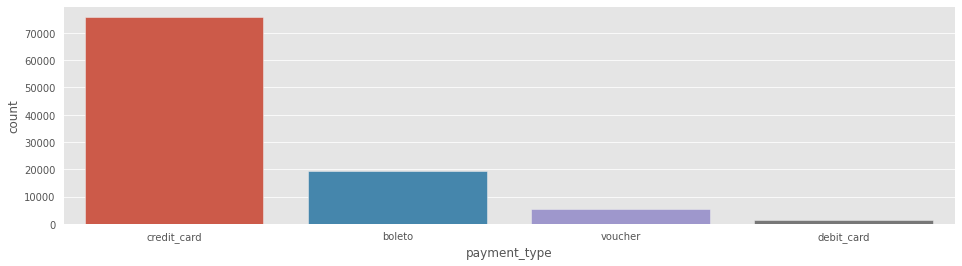

In [67]:
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=payment_orders)

plt.show()

#### Sales of best-selling products, show the same behavior as total sales

/home/ximena/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


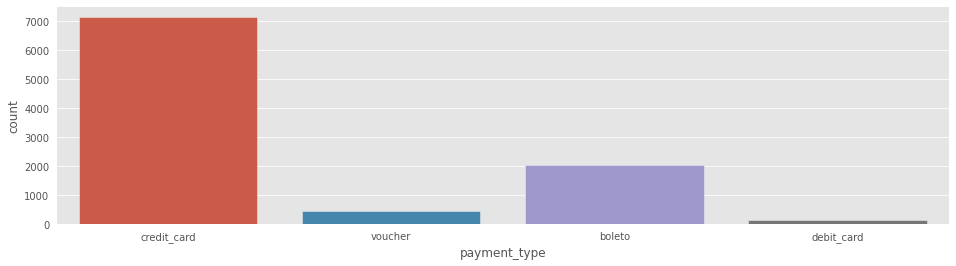

In [68]:
#Sales with more seller products(mor than 100 units per product)
dfrs = order_items.groupby('product_id').count()
dfrs.sort_values(by=['order_id'], ascending=False, inplace=True)
dfrs1 = dfrs[(dfrs['order_id']>100)]
ListProducts=dfrs1.index
ListOrders=order_items[(order_items['product_id'].isin(ListProducts))]['order_id'].unique()
pop=payment_orders[(payment_orders['order_id']).isin(ListOrders)]
plt.figure(figsize=(16, 4))
sns.countplot('payment_type',data=pop)
plt.show()

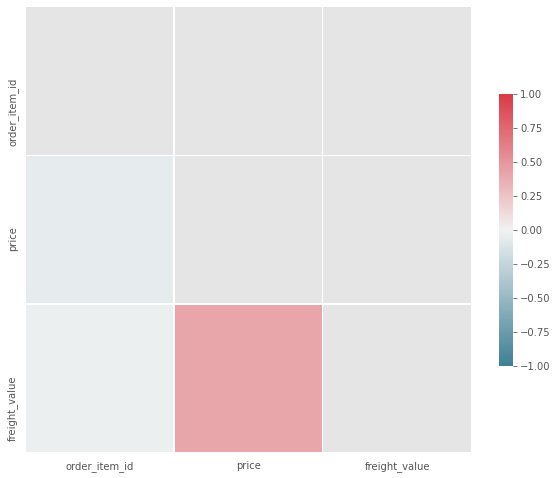

In [69]:
#compute correlation matrix
df_correlations = order_items.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

## There is no relevant information in a general line of time

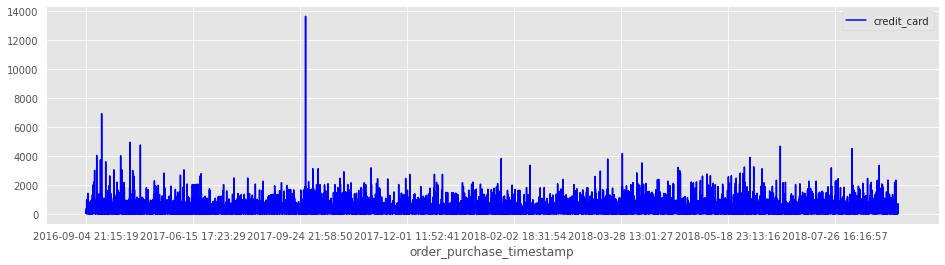

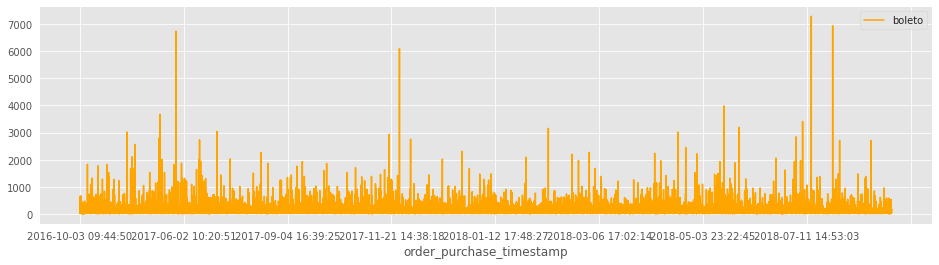

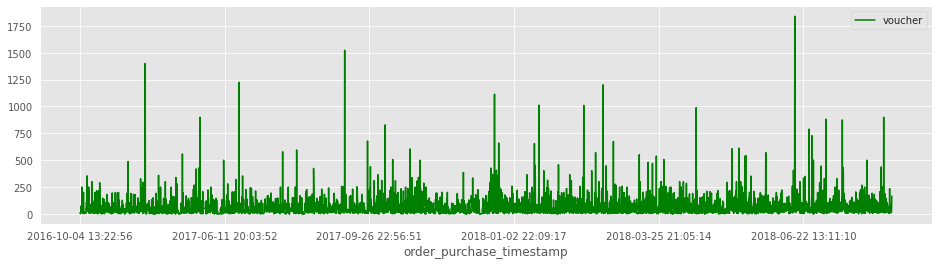

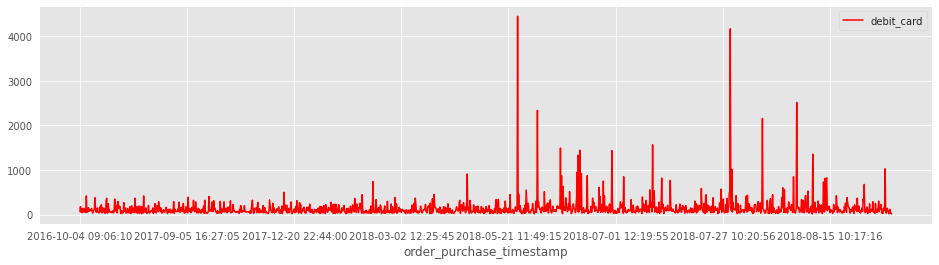

In [70]:
# Comportamiento en el tiempo por Tipo de Pago
payment_orders.sort_values(by=['order_purchase_timestamp'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']
for i,var in enumerate(listPaymentT):
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['order_purchase_timestamp','payment_value']]
    temp.plot(figsize=(16, 4), kind='line',x='order_purchase_timestamp',y='payment_value', color=color[i] ,label = var)
    plt.tittle = 'Payment Type ' + var
    #plt.xticks(rotation=90)
    #plt.legend()
plt.show()

## In Monthly bases Credit card payment has shown changes in September, payments with boleto show some peak in may, july and november,debit-card is more used in Jun to august

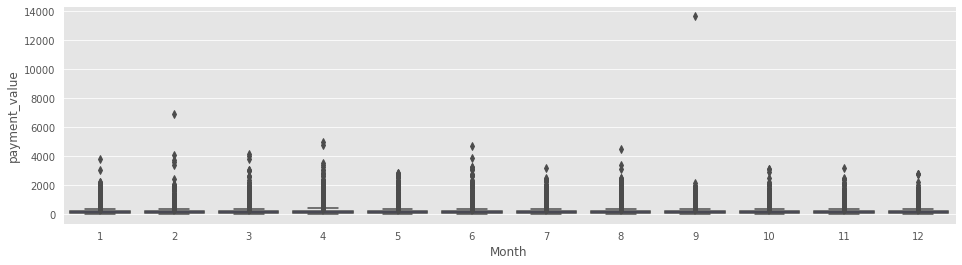

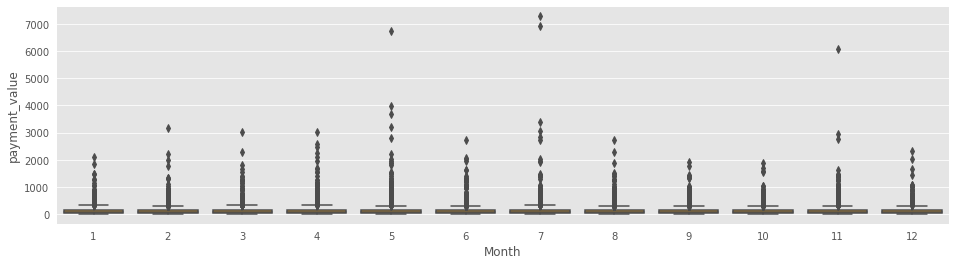

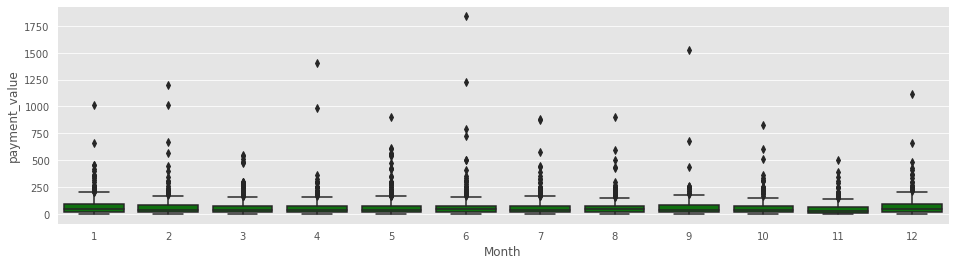

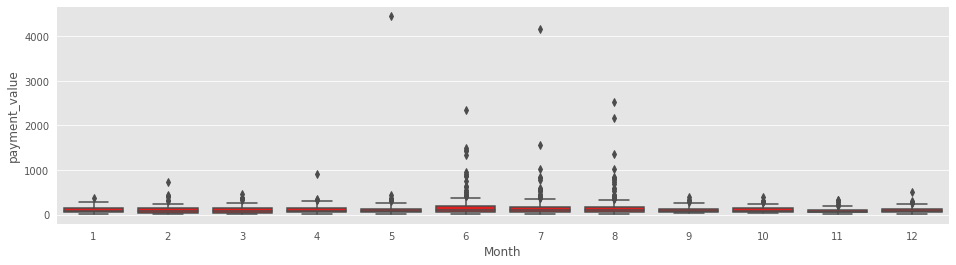

In [71]:
#Behavior Monthly by Payment Type

payment_orders.sort_values(by=['Month'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    #print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Month','payment_value']]
    #plt.subplot(2,2,i+1)
    sns.boxplot(x='Month',y='payment_value', data=temp ,color=color[i])
    #plt.tittle = 'Payment Type ' + var
    #plt.legend()
    plt.show()

## Thursday and Saturday shows peaks of buyers in credit card, boletos and bouchers are some disperse along week.

credit_card


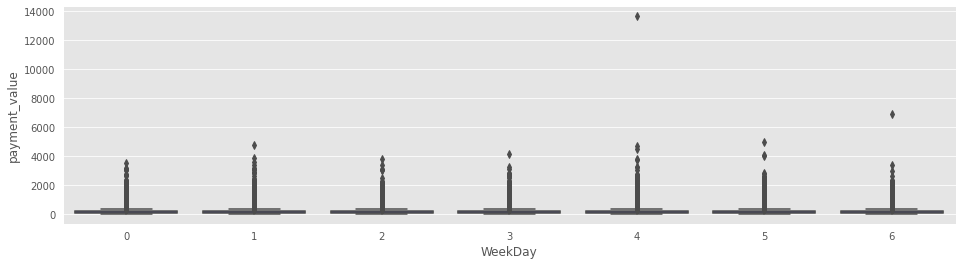

boleto


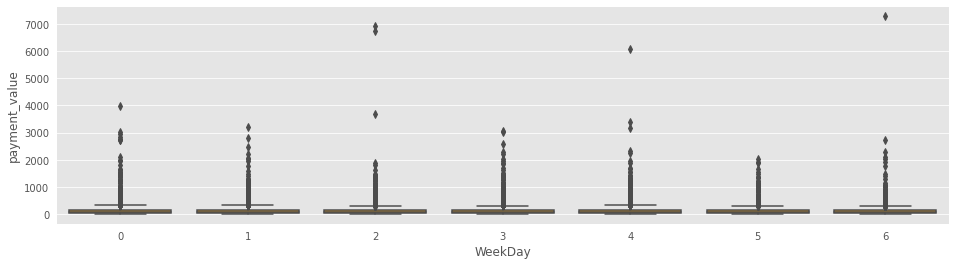

voucher


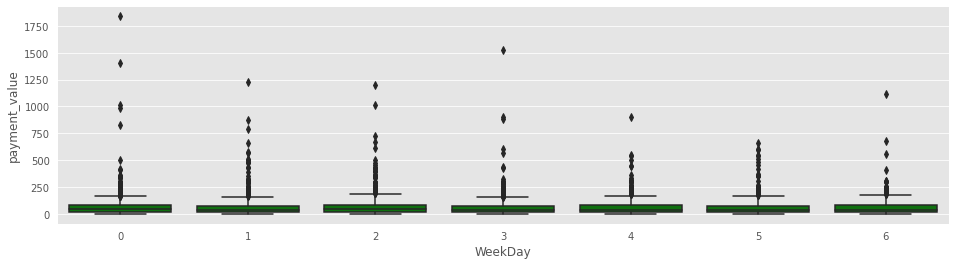

debit_card


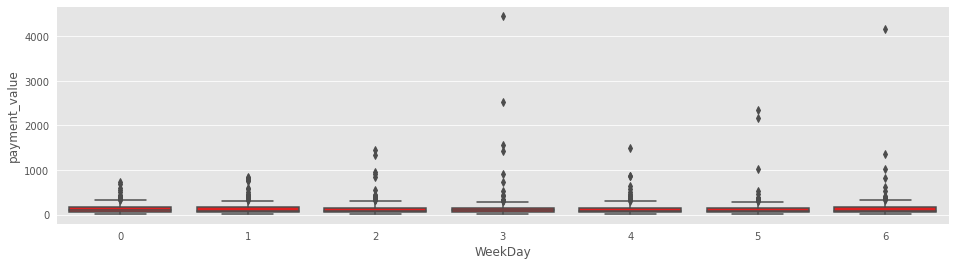

In [72]:
payment_orders.sort_values(by=['WeekDay'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Blue','Orange','Green','Red']

for i,var in enumerate(listPaymentT):
    plt.figure(figsize=(16, 4))
    print(var)
    temp = payment_orders[(payment_orders['payment_type'] == var)][['WeekDay','payment_value']]
    sns.boxplot(x='WeekDay',y='payment_value', data=temp ,color=color[i])
    plt.show()

credit_card


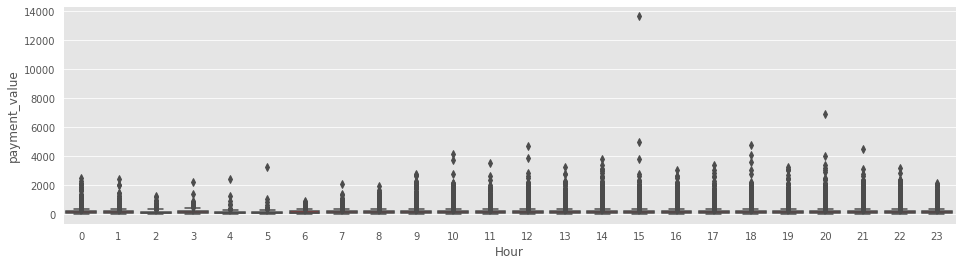

boleto


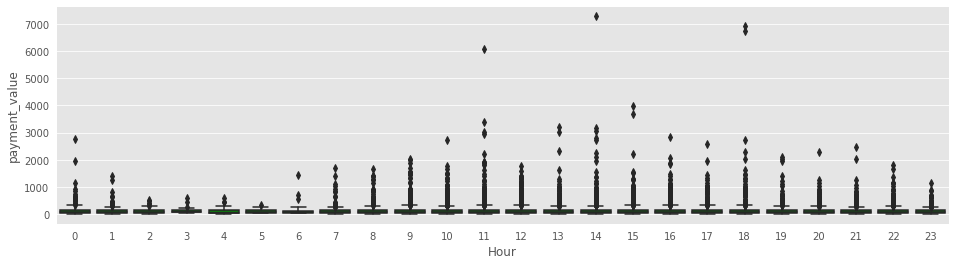

voucher


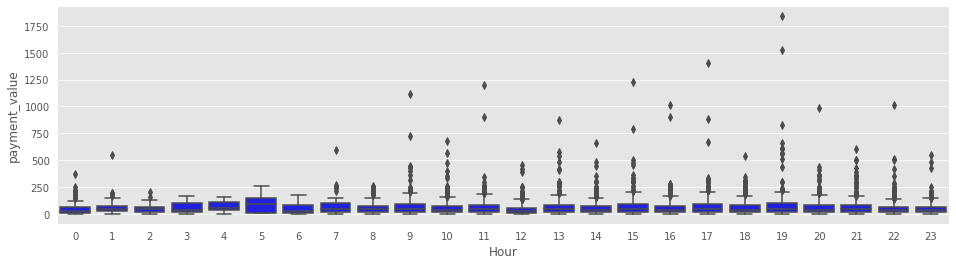

debit_card


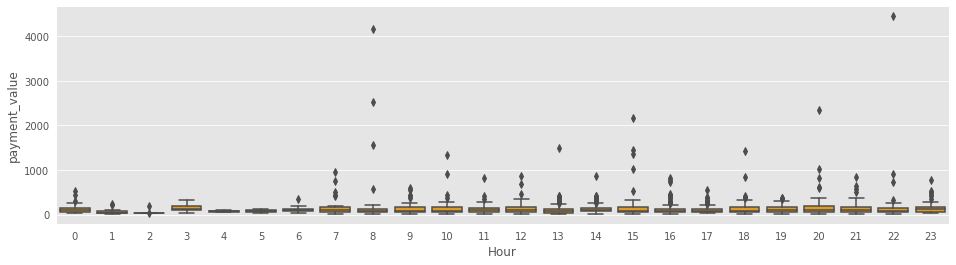

In [73]:
payment_orders.sort_values(by=['Hour'], inplace=True)
listPaymentT = ['credit_card','boleto','voucher','debit_card']
color = ['Red','Green','Blue','Orange']

for i,var in enumerate(listPaymentT):
    print(var)
    plt.figure(figsize=(16, 4))
    temp = payment_orders[(payment_orders['payment_type'] == var)][['Hour','payment_value']]
    sns.boxplot(x='Hour',y='payment_value', data=temp ,color=color[i])
    plt.show()


# Customer purchase trends

## Number of orders x Customer

The idea of this exploration of the data is to understand the number of orders made per customer, in order to understand the volume of purchases made by customers who buy the most.

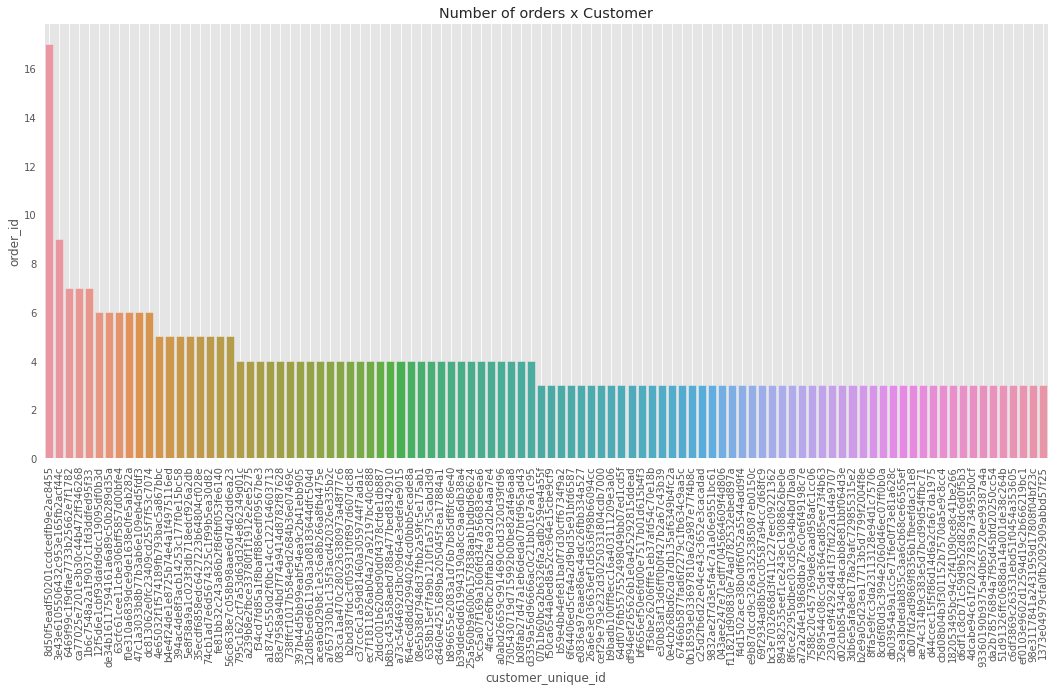

In [74]:
costumer_orders=pd.merge(customer, orders)
aux=costumer_orders.groupby(['customer_unique_id']).agg({'order_id':'count'}).reset_index()
aux=aux.sort_values(by='order_id',ascending=False).head(100)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='order_id',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Number of orders x Customer')
ax.grid()

Looking at the top 50 of purchases, they have more than 4  purchases in the period, with a couple of exceptions that they make more.

## Top Payments x customer

Regarding the amount of payments per customer, we can see that the top 50 customers have made purchases in the year for amounts close to US 3000, the average value of total purchases is US 154

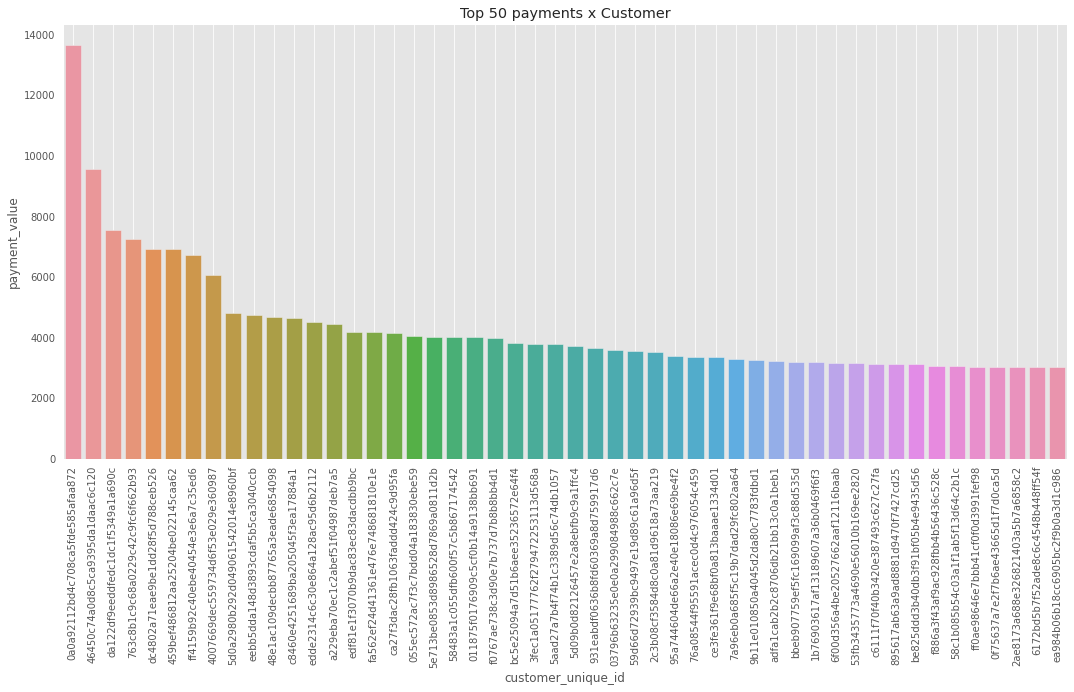

In [75]:
costumer_payments=pd.merge(costumer_orders, order_payments)
aux=costumer_payments.groupby(['customer_unique_id']).agg({'payment_value':'sum'}).reset_index()
aux=aux.sort_values(by='payment_value',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='customer_unique_id',y='payment_value',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 50 payments x Customer')
ax.grid()
top_customer=aux

In [76]:
costumer_payments.describe()

,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000,103886.000000
mean,35072.550555,1.092679,2.853349,154.100380
std,29743.491677,0.706584,2.687051,217.494064
min,1003.000000,1.000000,0.000000,0.000000
25%,11366.250000,1.000000,1.000000,56.790000
50%,24360.000000,1.000000,1.000000,100.000000
75%,58418.000000,1.000000,4.000000,171.837500
max,99990.000000,29.000000,24.000000,13664.080000


## Prices per product

Regarding the prices for the different product categories, we find that the most expensive products are related to the categories of Household utilities, Computers, Arts and electrical appliances. Within these, the highest price range refers to computers

<AxesSubplot:xlabel='price', ylabel='product_category_name'>

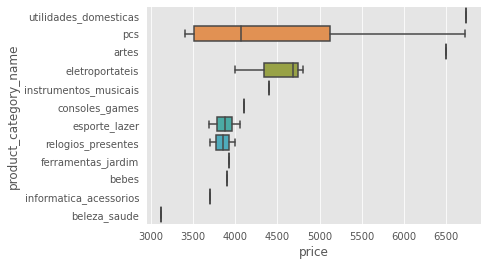

In [77]:
order_product=pd.merge(products, order_items)
top_products= order_product.sort_values(['price'],ascending=False).head(20)
sns.boxplot(y=top_products['product_category_name'], x=top_products["price"])


## Top Products sold

Regarding the best-selling products, the following categories have the highest amount of sales:

|Product Category   |Number of purchases |
|---|---|
|Cama_mesa_banho |11.823 |
|beleza_saude |9.972|
|esporte_lazer | 8.945|
|moveis_decoracao |8744| 
|informatica_acessorios |8082|
|utilidades_domesticas |7355|

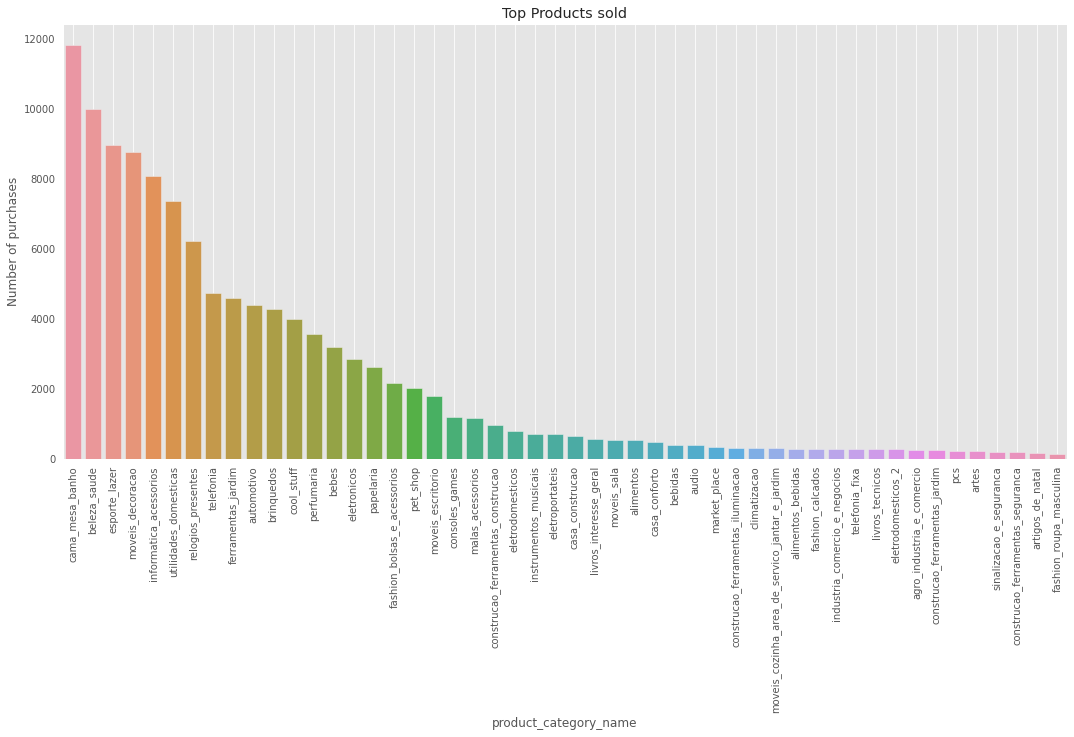

In [78]:
client_product=pd.merge(costumer_payments, order_product)
aux=client_product.groupby('product_category_name').size().to_frame().rename(columns={0:'Number of purchases'}).reset_index()
aux=aux.sort_values(by='Number of purchases',ascending=False).head(50)
plt.figure(figsize=(18, 8))
ax=sns.barplot(x='product_category_name',y='Number of purchases',data=aux);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top Products sold')
ax.grid()

## HYPOTHESIS FOR NEXT SUBMISSION

 
- 1  Standing in the graph presented in the secction "Difference between Delivered Time and Delivered Estimated Time vs Reviews", we could afirm that puntuality in the delivery time is correlated in a inverse relationship  for the review score when a costumer purchases a product online, and further insides in his decision of not buy in the same store again  
- 2  According with analysis section of payment methods The Percentage of Credit Card payment of General Customer is equal to the Percentage of Credit Card payment for Customer of best seller products  

- 3  The number of purchases by product category is associated with the region where the customer is located.  
- 4  Would be equivalent in hypothesizing that the amount of purchasing is higher on weekends.  
- 5  Would the buyers purchase more at nights 



## MODEL DEFINITION

In [2]:
Cus_ord_itm = pd.merge(left = df , right = order_items , how='left', left_on='order_id', right_on='order_id')
Cus_ord_itm.head() 

NameError: name 'pd' is not defined

In [1]:
timesMonth=[]
timesYear=[]
weekday=[]
hour=[]
for i in Cus_ord_itm['order_purchase_timestamp']:
    fecha=pd.to_datetime(i)
    timesMonth.append(fecha.month)
    timesYear.append(fecha.year)
    weekday.append(fecha.dayofweek)
    hour.append(fecha.hour)
Cus_ord_itm['Month']=timesMonth
Cus_ord_itm['Year']=timesYear
Cus_ord_itm['WeekDay']=weekday
Cus_ord_itm['Hour']=hour
Cus_ord_itm['YearMonth']=Cus_ord_itm['Year']*100+Cus_ord_itm['Month']
Cus_ord_itm.head()

NameError: name 'Cus_ord_itm' is not defined

In [ ]:
#compute correlation matrix
df_correlations = Cus_ord_itm.corr()
#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
#orders_by_date

In [ ]:
mod1 = smf.ols(formula='price~regions', data=Cus_ord_itm).fit()
print(mod1.summary())

In [ ]:
mod3 = smf.ols(formula='price~regions+product_category_name', data=Cus_ord_itm).fit()
print(mod3.summary())

In [ ]:
mod4 = smf.ols(formula='price~Year+Month', data=Cus_ord_itm).fit()
print(mod4.summary())

# Final Submission

In [ ]:
'''
customer = pd.read_csv(ruta+'olist_customers_dataset.csv', delimiter=',') 
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',') 
orders=pd.read_csv(ruta+'olist_orders_dataset.csv', delimiter=',') 
products=pd.read_csv(ruta+'olist_products_dataset.csv', delimiter=',') 
order_payments=pd.read_csv(ruta+'olist_order_payments_dataset.csv', delimiter=',')
reviews=pd.read_csv(ruta+'olist_order_reviews_dataset.csv', delimiter=',')
order_items=pd.read_csv(ruta+'olist_order_items_dataset.csv', delimiter=',')
sellers=pd.read_csv(ruta+'olist_sellers_dataset.csv', delimiter=',') 
'''


In [5]:
#Merge
#df=pd.merge(df1, df2, how="left", left_on="customer_id", right_on="customer_id")
merged_df=pd.merge(order_payments, orders, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, reviews, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, customer, how='left', left_on='customer_id', right_on='customer_id')
merged_df=pd.merge(merged_df, order_items, how='left', left_on='order_id', right_on='order_id')
merged_df=pd.merge(merged_df, products, how='left', left_on='product_id', right_on='product_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df=pd.merge(merged_df, sellers, how='left', left_on='seller_id', right_on='seller_id')
merged_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix_x,seller_city_x,seller_state_x,seller_zip_code_prefix_y,seller_city_y,seller_state_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,...,800.0,17.0,27.0,17.0,13321.0,salto,SP,13321.0,salto,SP
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,...,150.0,16.0,6.0,11.0,4660.0,sao paulo,SP,4660.0,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,...,250.0,20.0,8.0,21.0,9015.0,santo andre,SP,9015.0,santo andre,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,1200.0,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP
4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,1200.0,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP


In [6]:
merged_df.describe()

,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix_x,seller_zip_code_prefix_y
count,119148.000000,119148.000000,119148.000000,119148.000000,119148.000000,118315.000000,118315.000000,118315.000000,116606.000000,116606.000000,116606.000000,118295.000000,118295.000000,118295.000000,118295.000000,118315.000000,118315.000000
mean,1.094731,2.941426,172.735670,3.998590,35034.467754,1.196509,120.651027,20.033024,48.767782,785.944008,2.205144,2112.331011,30.265227,16.620009,23.075075,24440.790703,24440.790703
std,0.730117,2.777992,267.770023,1.412467,29823.423368,0.699452,184.109626,15.836523,10.033375,652.578636,1.717429,3786.717861,16.189038,13.453941,11.749311,27571.679456,27571.679456
min,1.000000,0.000000,0.000000,1.000000,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1001.000000
25%,1.000000,1.000000,60.850000,3.000000,11250.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,6429.000000
50%,1.000000,2.000000,108.160000,5.000000,24240.000000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,13660.000000
75%,1.000000,4.000000,189.240000,5.000000,58478.000000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,27946.500000,27946.500000
max,29.000000,24.000000,13664.080000,5.000000,99990.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,99730.000000


In [7]:
#Data['pay'] = Data['income'] + Data['bonus']
merged_df['total_pay'] = merged_df['price']+merged_df['freight_value']
merged_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix_x,seller_city_x,seller_state_x,seller_zip_code_prefix_y,seller_city_y,seller_state_y,total_pay
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,...,17.0,27.0,17.0,13321.0,salto,SP,13321.0,salto,SP,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,...,16.0,6.0,11.0,4660.0,sao paulo,SP,4660.0,sao paulo,SP,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,...,20.0,8.0,21.0,9015.0,santo andre,SP,9015.0,santo andre,SP,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP,107.78
4,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,...,44.0,2.0,35.0,13405.0,piracicaba,SP,13405.0,piracicaba,SP,107.78


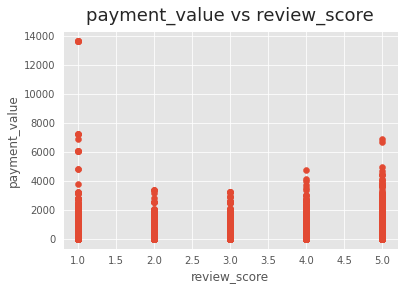

In [8]:
plt.scatter(merged_df['review_score'],merged_df['payment_value'])
plt.title("payment_value vs review_score", fontsize=18, verticalalignment='bottom')
plt.xlabel("review_score")
plt.ylabel("payment_value");

Text(0.5, 1.0, 'review_score vs payment_value')

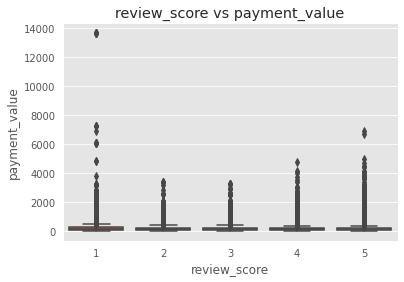

In [9]:
sns.boxplot(x='review_score', y='payment_value', data = merged_df)
plt.title('review_score vs payment_value')

In [10]:
corr_mat  = merged_df.corr()
corr_mat

,payment_sequential,payment_installments,payment_value,review_score,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix_x,seller_zip_code_prefix_y,total_pay
payment_sequential,1.000000,-0.086509,-0.064466,-0.004949,-0.021976,-0.002869,0.006837,0.022343,-0.005580,0.009941,-0.010824,0.043982,0.048961,0.024475,0.031060,0.014274,0.014274,0.008432
payment_installments,-0.086509,1.000000,0.273657,-0.041211,0.056266,0.073810,0.277672,0.185711,0.020871,0.035988,0.000093,0.177539,0.117629,0.122308,0.137922,0.039067,0.039067,0.282698
payment_value,-0.064466,0.273657,1.000000,-0.084434,0.054504,0.265213,0.739242,0.373767,0.002384,0.156120,0.010081,0.303332,0.138758,0.217183,0.148611,0.069810,0.069810,0.742632
review_score,-0.004949,-0.041211,-0.084434,1.000000,-0.021529,-0.131881,-0.005463,-0.037346,-0.005861,0.009803,0.022322,-0.028854,-0.021160,-0.026753,-0.010957,0.026234,0.026234,-0.008352
customer_zip_code_prefix,-0.021976,0.056266,0.054504,-0.021529,1.000000,-0.000513,0.043133,0.225495,0.015811,0.025408,0.020504,0.001618,0.004300,0.011654,-0.011346,0.075785,0.075785,0.060198
order_item_id,-0.002869,0.073810,0.265213,-0.131881,-0.000513,1.000000,-0.060452,-0.030666,-0.024110,-0.015063,-0.054428,-0.004322,0.005379,0.029166,-0.009446,-0.018391,-0.018391,-0.060737
price,0.006837,0.277672,0.739242,-0.005463,0.043133,-0.060452,1.000000,0.415940,0.018025,0.201773,0.052813,0.339373,0.145580,0.224352,0.172631,0.088378,0.088378,0.997160
freight_value,0.022343,0.185711,0.373767,-0.037346,0.225495,-0.030666,0.415940,1.000000,0.022601,0.096523,0.022313,0.611596,0.309653,0.393887,0.325324,0.152137,0.152137,0.483242
product_name_lenght,-0.005580,0.020871,0.002384,-0.005861,0.015811,-0.024110,0.018025,0.022601,1.000000,0.090256,0.145427,0.020733,0.058616,-0.030865,0.062111,-0.032641,-0.032641,0.019226
product_description_length,0.009941,0.035988,0.156120,0.009803,0.025408,-0.015063,0.201773,0.096523,0.090256,1.000000,0.117915,0.063584,0.007487,0.074137,-0.068264,0.062237,0.062237,0.202232


Text(0.5, 1.0, 'Correlation Matrix')

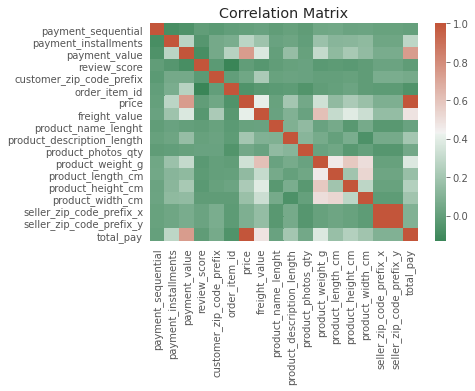

In [11]:
sns.heatmap(corr_mat,cmap=sns.diverging_palette(500, 20, as_cmap=True))
plt.title("Correlation Matrix")

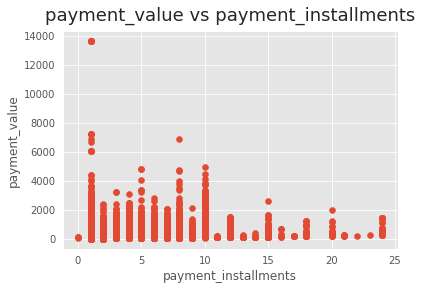

In [12]:
plt.scatter(merged_df['payment_installments'],merged_df['payment_value'])
plt.title("payment_value vs payment_installments", fontsize=18, verticalalignment='bottom')
plt.xlabel("payment_installments")
plt.ylabel("payment_value");

In [13]:
merged_df['customer_id'].unique()

array(['0a8556ac6be836b46b3e89920d59291c',
       'f2c7fc58a9de810828715166c672f10a',
       '25b14b69de0b6e184ae6fe2755e478f9', ...,
       'e4abb5057ec8cfda9759c0dc415a8188',
       '5d719b0d300663188169c6560e243f27',
       '4c7f868f43b5cff577b0becb8c8b7860'], dtype=object)

# Regiones Cristian

In [15]:
merged_df.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix_x',
       'seller_city_x', 'seller_state_x', 'seller_zip_code_prefix_y',
       'seller_city_y', 'seller_state_y', 'total_pay

In [16]:
estados= {'AC':'Acre', 'AL':'Alagoas', 'AM':'Amazonas', 'AP':'Amapá', 'BA':'Bahía', 'CE':'Ceará',
          'DF':'Distrito Federal', 'ES':'Espírito Santo', 'GO':'Goiás', 'MA':'Maranhão', 'MG':'Minas Gerais',
          'MS':'Mato Grosso del Sur', 'MT':'Mato Grosso', 'PA':'Pará', 'PB':'Paraíba', 'PE':'Pernambuco',
          'PI':'Piauí', 'PR':'Paraná', 'RJ':'Río de Janeiro', 'RN':'Río Grande del Norte', 'RO':'Rondonia',
          'RR':'Roraima', 'RS':'Río Grande del Sur', 'SC':'Santa Catarina', 'SE':'Sergipe', 'SP':'São Paulo', 'TO':'Tocantins'}
merged_df['name_state'] = merged_df['customer_state']
for i in range(len(estados)):
    merged_df["name_state"]=merged_df["name_state"].str.replace(list(estados.keys())[i],list(estados.values())[i])
merged_df['name_state'].head()

0    Minas Gerais
1       São Paulo
2       São Paulo
3    Minas Gerais
4    Minas Gerais
Name: name_state, dtype: object

In [17]:
region = ["Norte","Sur","Sudeste","Nordeste","CentroOeste"]
regiones= {'AC':'Norte', 'AL':'Nordeste', 'AM':'Norte', 'AP':'Norte', 'BA':'Nordeste',
           'CE':'Nordeste', 'DF':'CentroOeste', 'ES':'Sudeste', 'GO':'CentroOeste',
           'MA':'Nordeste', 'MG':'Sudeste', 'MS':'CentroOeste', 'MT':'CentroOeste',
           'PA':'Norte', 'PB':'Nordeste', 'PE':'Nordeste', 'PI':'Nordeste', 'PR':'Sur',
           'RJ':'Sudeste', 'RN':'Nordeste', 'RO':'Norte', 'RR':'Norte', 'RS':'Sur',
           'SC':'Sur', 'SE':'Nordeste', 'SP':'Sudeste', 'TO':'Norte'}
merged_df['regions']=merged_df['customer_state']
for i in range(len(estados)):
    merged_df["regions"]=merged_df["regions"].str.replace(list(regiones.keys())[i],list(regiones.values())[i])

merged_df['regions'].head()

0    Sudeste
1    Sudeste
2    Sudeste
3    Sudeste
4    Sudeste
Name: regions, dtype: object

In [24]:
merged_df['ano_mes']=merged_df['order_purchase_timestamp'].str.split('-', expand=True)[0]+"-"+merged_df['order_purchase_timestamp'].str.split('-', expand=True)[1]
merged_df['ano_mes_dt'] = pd.to_datetime(merged_df['ano_mes'])
merged_df['fecha'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['Year']= merged_df['fecha'].dt.year
merged_df['mes']= merged_df['fecha'].dt.month
merged_df.ano_mes = merged_df.ano_mes.astype('category')
merged_df['codes']= merged_df.ano_mes.cat.codes

In [30]:
Regional_Estimation = merged_df[['regions', 'total_pay', 'Year', 'mes']]
Regional_Estimation.head(10)

,regions,total_pay,Year,mes
0,Sudeste,99.33,2018,4
1,Sudeste,24.39,2018,6
2,Sudeste,65.71,2017,12
3,Sudeste,107.78,2017,12
4,Sudeste,107.78,2017,12
5,Sudeste,128.45,2018,5
6,Sudeste,48.06,2018,5
7,Sudeste,48.06,2018,5
8,Sudeste,81.16,2017,6
9,Sudeste,51.84,2017,6


In [48]:
Regional_Estimation1 = Regional_Estimation.groupby(['regions', 'Year', 'mes']).agg({'total_pay': ['sum']})   
Regional_Estimation1 = Regional_Estimation1.reset_index()
Regional_Estimation1

,regions,Year,mes,total_pay
,,,,sum
0,CentroOeste,2016,10,2955.96
1,CentroOeste,2017,1,9330.93
2,CentroOeste,2017,2,25362.43
3,CentroOeste,2017,3,29450.95
4,CentroOeste,2017,4,38960.04
...,...,...,...,...
108,Sur,2018,5,169623.13
109,Sur,2018,6,147350.63
110,Sur,2018,7,149573.94


In [49]:
Regional_Estimation1['mes'] = Regional_Estimation1.mes.map("{:02}".format)

In [61]:
Regional_Estimation1['Year_Month'] = (Regional_Estimation1['Year'].astype(str) + '/' + Regional_Estimation1['mes'].astype(str))
Regional_Estimation1['Complete_Date'] = pd.to_datetime(Regional_Estimation1['Year_Month'])
Regional_Estimation1

,regions,Year,mes,total_pay,Year_Month,Complete_Date
,,,,sum,,
0,CentroOeste,2016,10,2955.96,2016/10,2016-10-01
1,CentroOeste,2017,01,9330.93,2017/01,2017-01-01
2,CentroOeste,2017,02,25362.43,2017/02,2017-02-01
3,CentroOeste,2017,03,29450.95,2017/03,2017-03-01
4,CentroOeste,2017,04,38960.04,2017/04,2017-04-01
...,...,...,...,...,...,...
108,Sur,2018,05,169623.13,2018/05,2018-05-01
109,Sur,2018,06,147350.63,2018/06,2018-06-01
110,Sur,2018,07,149573.94,2018/07,2018-07-01


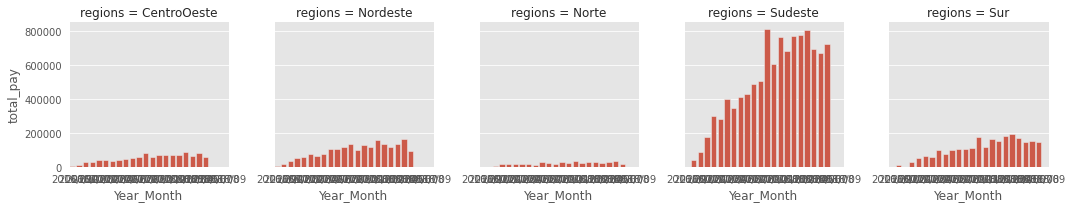

In [62]:
g = sns.FacetGrid(Regional_Estimation1, col="regions")
g.map(sns.barplot,'Year_Month','total_pay');

In [60]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Regional_Estimation1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              total_pay   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                 -0.084
Method:                 Least Squares   F-statistic:                    0.6398
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.893
Time:                        23:50:26   Log-Likelihood:                -1534.7
No. Observations:                 113   AIC:                             3119.
Df Residuals:                      88   BIC:                             3188.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [67]:
Estimation_CentroOeste = Regional_Estimation1[Regional_Estimation1.regions == "CentroOeste"]
Estimation_CentroOeste = Estimation_CentroOeste[['Year_Month', 'total_pay']]
Estimation_CentroOeste.head()

,Year_Month,total_pay
,,sum
0,2016/10,2955.96
1,2017/01,9330.93
2,2017/02,25362.43
3,2017/03,29450.95
4,2017/04,38960.04


In [68]:
formula = 'total_pay~Year_Month'
model   = sfm.ols(formula = formula, data = Estimation_CentroOeste).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              total_pay   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 17 Dec 2020   Prob (F-statistic):                nan
Time:                        00:03:10   Log-Likelihood:                 486.22
No. Observations:                  21   AIC:                            -930.4
Df Residuals:                       0   BIC:                            -908.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2955.96

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
